# Imports

In [598]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, r2_score, roc_auc_score

In [393]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [395]:
### -------------LOCAL MODE-----------------
# Load the data using the data loading module
data_dir = "./data/"

In [398]:
df_social_dem = pd.read_csv(os.path.join(data_dir, "Soc_Dem.csv"))
df_product_actbalance = pd.read_csv(os.path.join(data_dir, "Products_ActBalance.csv"))
df_sales_revenues = pd.read_csv(os.path.join(data_dir, "Sales_Revenues.csv"))
df_inflow_outflow = pd.read_csv(os.path.join(data_dir, "Inflow_Outflow.csv"))

# Exploratory Analysis

## Social Demographic analysis

In [399]:
df_social_dem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Client  1615 non-null   int64 
 1   Sex     1612 non-null   object
 2   Age     1615 non-null   int64 
 3   Tenure  1615 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 50.6+ KB


- Gender is missing for 3 records. Impute with mode

In [400]:
print("\nSummary Statistics:\n")
print(df_social_dem.describe(include='all'))


Summary Statistics:

             Client   Sex          Age       Tenure
count   1615.000000  1612  1615.000000  1615.000000
unique          NaN     2          NaN          NaN
top             NaN     M          NaN          NaN
freq            NaN   856          NaN          NaN
mean     808.000000   NaN    42.848916   101.339938
std      466.354658   NaN    18.550529    64.917297
min        1.000000   NaN     0.000000     0.000000
25%      404.500000   NaN    29.000000    44.000000
50%      808.000000   NaN    41.000000    97.000000
75%     1211.500000   NaN    57.000000   151.000000
max     1615.000000   NaN    97.000000   273.000000


In [401]:
# check for duplicated entries
duplicated_clients = df_social_dem['Client'].duplicated().sum()
print(f"\nDuplicated client IDs: {duplicated_clients}")


Duplicated client IDs: 0



Sex Feature Analysis:
Value Counts:
Sex
M    856
F    756
Name: count, dtype: int64


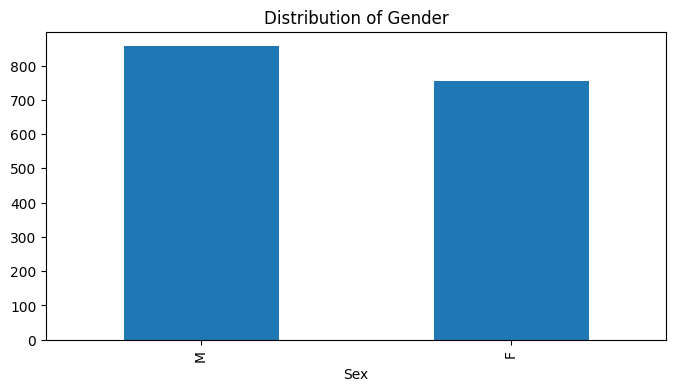

In [402]:
# ---  "Sex" feature ---
print("\nSex Feature Analysis:")
print(f"Value Counts:\n{df_social_dem['Sex'].value_counts()}")
plt.figure(figsize=(8, 4))
df_social_dem['Sex'].value_counts().plot(kind='bar')
plt.title('Distribution of Gender')
plt.show()

### <b> INSIGHT </b>
- Gender distribution of clients is not too skewed


Age Feature Analysis:


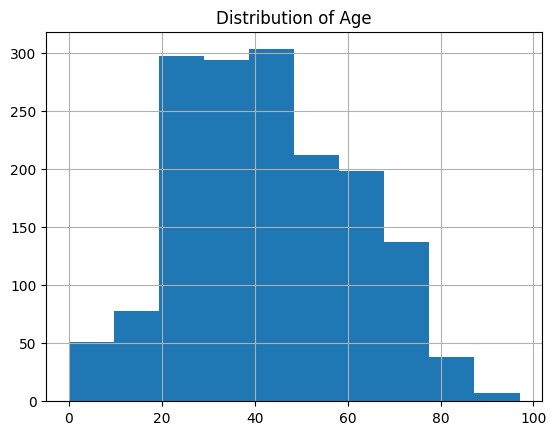

count    1615.000000
mean       42.848916
std        18.550529
min         0.000000
25%        29.000000
50%        41.000000
75%        57.000000
max        97.000000
Name: Age, dtype: float64
Median age : 41.0


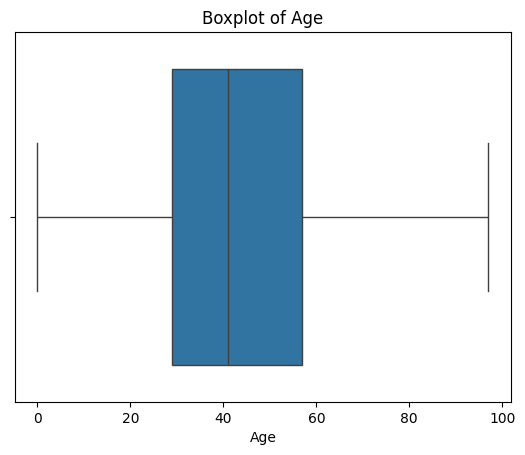

In [403]:
# --- Age Feature ---
print("\nAge Feature Analysis:")
df_social_dem['Age'].hist()
plt.title("Distribution of Age")
plt.show()
print(df_social_dem['Age'].describe())
print(f"Median age : {df_social_dem['Age'].median()}")

sns.boxplot(x=df_social_dem['Age'])
plt.title("Boxplot of Age")
plt.show()

### <b> INSIGHT </b>
- Age distribution is close to normal
- There seem to be no outliers in age


Tenure Feature Analysis:


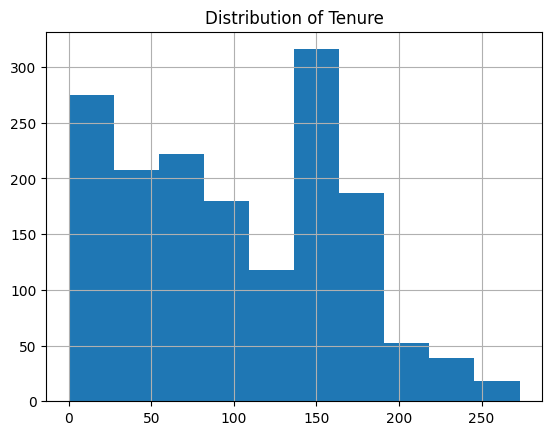

count    1615.000000
mean      101.339938
std        64.917297
min         0.000000
25%        44.000000
50%        97.000000
75%       151.000000
max       273.000000
Name: Tenure, dtype: float64
Median tenure : 97.0


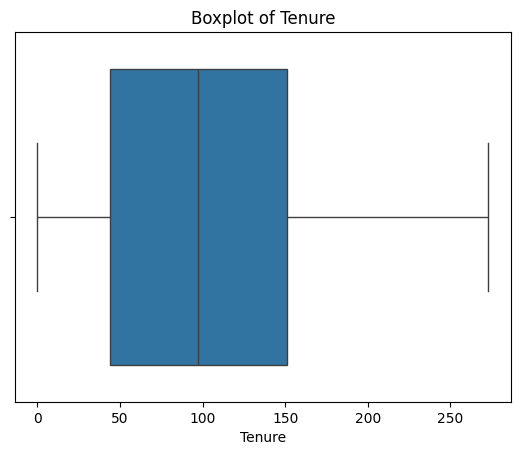

In [404]:
# --- Tenure Feature ---
print("\nTenure Feature Analysis:")
df_social_dem['Tenure'].hist()
plt.title("Distribution of Tenure")
plt.show()
print(df_social_dem['Tenure'].describe())
print(f"Median tenure : {df_social_dem['Tenure'].median()}")
sns.boxplot(x=df_social_dem['Tenure'])
plt.title("Boxplot of Tenure")
plt.show()


### <b> INSIGHT </b>
- Median tenure is 97 months or about 8 years
- Max is 273 months or about 22.75 years

## Product Account Balance analysis

In [405]:
print("\nData Info:\n")
print(df_product_actbalance.info())


Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Client      1615 non-null   int64  
 1   Count_CA    1615 non-null   int64  
 2   Count_SA    426 non-null    float64
 3   Count_MF    306 non-null    float64
 4   Count_OVD   419 non-null    float64
 5   Count_CC    170 non-null    float64
 6   Count_CL    135 non-null    float64
 7   ActBal_CA   1615 non-null   float64
 8   ActBal_SA   426 non-null    float64
 9   ActBal_MF   306 non-null    float64
 10  ActBal_OVD  419 non-null    float64
 11  ActBal_CC   170 non-null    float64
 12  ActBal_CL   135 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 164.2 KB
None


In [406]:
print("\nSummary Statistics:\n")
print(df_product_actbalance.describe(include='all'))


Summary Statistics:

            Client     Count_CA    Count_SA    Count_MF  Count_OVD  Count_CC  \
count  1615.000000  1615.000000  426.000000  306.000000      419.0     170.0   
mean    808.000000     1.078638    1.166667    4.676471        1.0       1.0   
std     466.354658     0.333035    0.468205    7.845009        0.0       0.0   
min       1.000000     1.000000    1.000000    1.000000        1.0       1.0   
25%     404.500000     1.000000    1.000000    1.000000        1.0       1.0   
50%     808.000000     1.000000    1.000000    2.000000        1.0       1.0   
75%    1211.500000     1.000000    1.000000    5.000000        1.0       1.0   
max    1615.000000     4.000000    5.000000   79.000000        1.0       1.0   

         Count_CL      ActBal_CA      ActBal_SA      ActBal_MF   ActBal_OVD  \
count  135.000000    1615.000000     426.000000     306.000000   419.000000   
mean     1.185185    2438.601941   15201.520284   20517.533479   126.449897   
std      0.520980   

In [407]:
# check for duplicated entries
duplicated_clients = df_product_actbalance['Client'].duplicated().sum()
print(f"\nDuplicated client IDs: {duplicated_clients}")


Duplicated client IDs: 0



Count Feature Analysis:

Feature: Count_CA
Value Counts:
Count_CA
1    1515
2      77
3      19
4       4
Name: count, dtype: int64


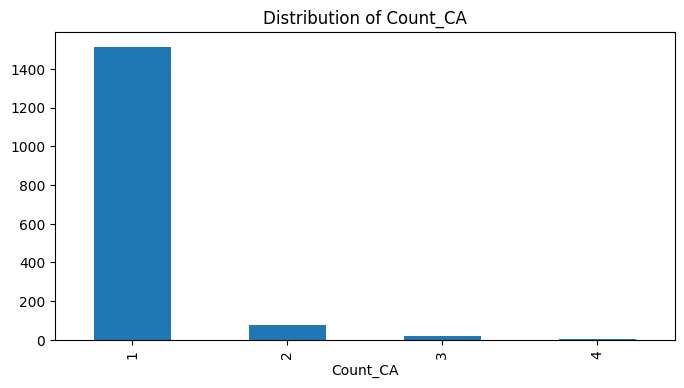


Feature: Count_SA
Value Counts:
Count_SA
1.0    369
2.0     45
3.0     11
5.0      1
Name: count, dtype: int64


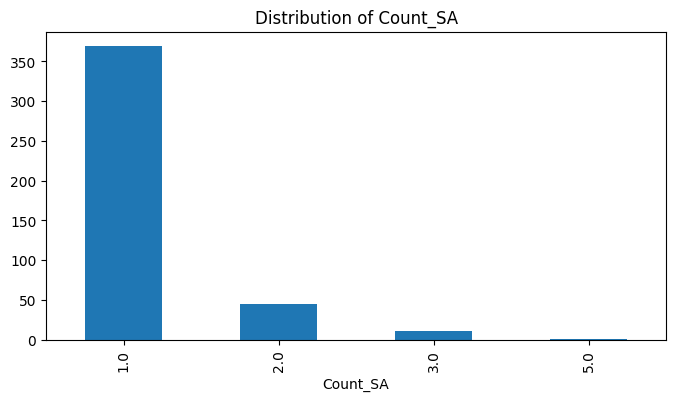


Feature: Count_MF
Value Counts:
Count_MF
1.0     102
2.0      53
3.0      42
4.0      31
5.0      14
6.0      14
7.0      10
11.0      6
8.0       5
9.0       4
10.0      4
26.0      2
12.0      2
18.0      2
35.0      1
64.0      1
45.0      1
22.0      1
20.0      1
17.0      1
79.0      1
14.0      1
19.0      1
28.0      1
13.0      1
27.0      1
15.0      1
25.0      1
32.0      1
Name: count, dtype: int64


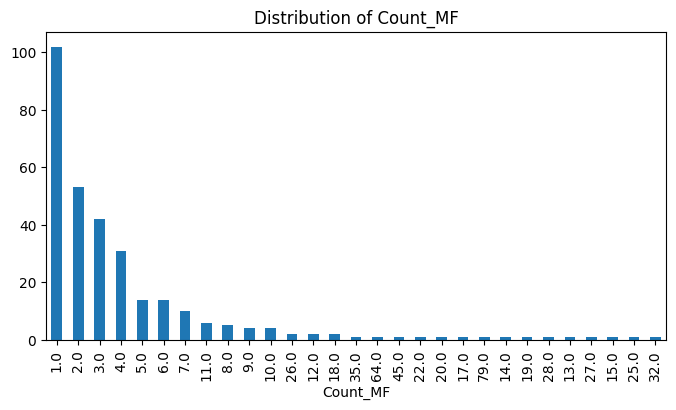


Feature: Count_OVD
Value Counts:
Count_OVD
1.0    419
Name: count, dtype: int64


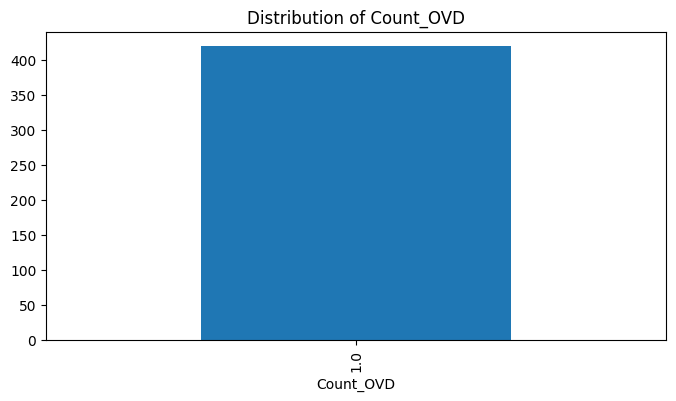


Feature: Count_CC
Value Counts:
Count_CC
1.0    170
Name: count, dtype: int64


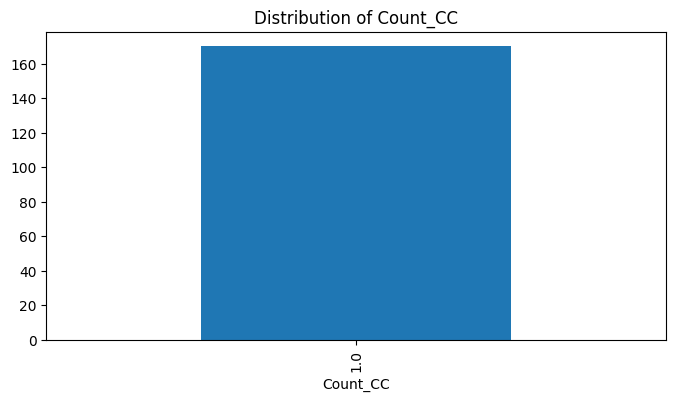


Feature: Count_CL
Value Counts:
Count_CL
1.0    115
2.0     17
3.0      2
5.0      1
Name: count, dtype: int64


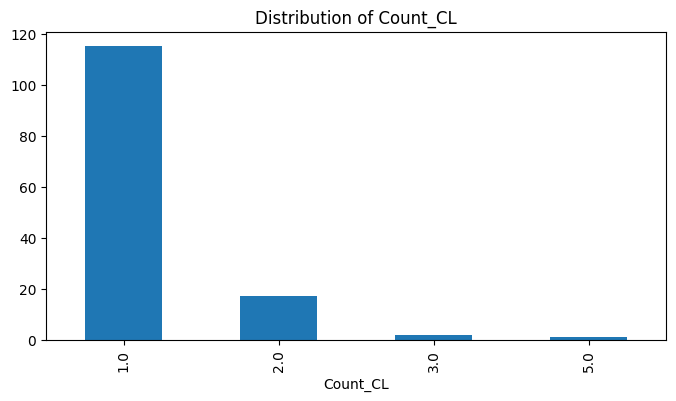

In [408]:
# ---  Product Count columns analysis ---
count_cols = ['Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL']
print("\nCount Feature Analysis:")
for count_col in count_cols:
    print(f"\nFeature: {count_col}")
    print(f"Value Counts:\n{df_product_actbalance[count_col].value_counts()}")
    plt.figure(figsize=(8, 4))
    df_product_actbalance[count_col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {count_col}')
    plt.show()

### <b> INSIGHT </b>
- Many Nulls in Product_ActBalance dataframe. Missing values need to be imputed
- Overdraft and Credit cards are only one per client. This means the company allows only one loan account for OD and Credit Card
- Current accounts, Savings accounts, Mutual Funds and Consumer Loans are more than one per client in some cases
- Max Mutual Funds that a client holds is 79, which is surprisingly high.

### Find missing in each product count column

In [409]:
print("\nFind missing in each Product Count Feature:")
for count_col in count_cols:
    missing_count = df_product_actbalance[count_col].isnull().sum()
    print(f" NULLs in {count_col}: {missing_count}")


Find missing in each Product Count Feature:
 NULLs in Count_CA: 0
 NULLs in Count_SA: 1189
 NULLs in Count_MF: 1309
 NULLs in Count_OVD: 1196
 NULLs in Count_CC: 1445
 NULLs in Count_CL: 1480


### Find inconsistencies between Product count and Account balance

In [410]:
product_pairs = {
    'Count_CA': 'ActBal_CA',
    'Count_SA': 'ActBal_SA',
    'Count_MF': 'ActBal_MF',
    'Count_OVD': 'ActBal_OVD',
    'Count_CC': 'ActBal_CC',
    'Count_CL': 'ActBal_CL'
}

In [411]:
# Check for inconsitent data. If count is missing, then the account balance also has to be null and vice versa
for count_col, balance_col in product_pairs.items():
  df_subset = df_product_actbalance[[count_col,balance_col]]

  # check for cases with Count >= 1 and Bal is NaN
  count_but_missing_bal = df_subset[(df_subset[count_col] >= 1) & (df_subset[balance_col].isnull())]

  # check for cases with Count is NaN but Bal is not NaN
  missing_count_but_with_bal = df_subset[(df_subset[count_col].isnull()) & (df_subset[balance_col].notnull())]

  print(f"\nInconsistencies for {count_col} & {balance_col}:")
  print(f"  Clients with {count_col} => 1 and missing {balance_col}: {len(count_but_missing_bal)}")
  print(f"  Clients with {count_col} is NaN but with {balance_col}: {len(missing_count_but_with_bal)}")


Inconsistencies for Count_CA & ActBal_CA:
  Clients with Count_CA => 1 and missing ActBal_CA: 0
  Clients with Count_CA is NaN but with ActBal_CA: 0

Inconsistencies for Count_SA & ActBal_SA:
  Clients with Count_SA => 1 and missing ActBal_SA: 0
  Clients with Count_SA is NaN but with ActBal_SA: 0

Inconsistencies for Count_MF & ActBal_MF:
  Clients with Count_MF => 1 and missing ActBal_MF: 0
  Clients with Count_MF is NaN but with ActBal_MF: 0

Inconsistencies for Count_OVD & ActBal_OVD:
  Clients with Count_OVD => 1 and missing ActBal_OVD: 0
  Clients with Count_OVD is NaN but with ActBal_OVD: 0

Inconsistencies for Count_CC & ActBal_CC:
  Clients with Count_CC => 1 and missing ActBal_CC: 0
  Clients with Count_CC is NaN but with ActBal_CC: 0

Inconsistencies for Count_CL & ActBal_CL:
  Clients with Count_CL => 1 and missing ActBal_CL: 0
  Clients with Count_CL is NaN but with ActBal_CL: 0


- No inconsistencies found in the data. If the product exists, then the balance also exists and vice versa

In [412]:
# check for cases where balances are zero
clients_product_count_but_zero_bal = pd.DataFrame(columns=['Client', 'product', 'count_value'])
for count_col, balance_col in product_pairs.items():
  df_subset = df_product_actbalance[["Client",count_col,balance_col]]

  # check for cases with Count = 1 and Bal is 0
  count_but_zero_bal = df_subset[(df_subset[count_col] >= 1) & (df_subset[balance_col] == 0)]
  print(f"\n Inconsistencies for {count_col} & {balance_col}:")
  print(f"  Clients with {count_col} = 1 and {balance_col} = 0: {len(count_but_zero_bal)}")
  if not count_but_zero_bal.empty:
      temp_df = count_but_zero_bal[['Client',count_col]].copy()
      temp_df.rename(columns = {count_col:"count_value"}, inplace = True)
      temp_df["product"] = count_col
      clients_product_count_but_zero_bal = pd.concat([clients_product_count_but_zero_bal, temp_df],ignore_index=True)


 Inconsistencies for Count_CA & ActBal_CA:
  Clients with Count_CA = 1 and ActBal_CA = 0: 94

 Inconsistencies for Count_SA & ActBal_SA:
  Clients with Count_SA = 1 and ActBal_SA = 0: 16

 Inconsistencies for Count_MF & ActBal_MF:
  Clients with Count_MF = 1 and ActBal_MF = 0: 111

 Inconsistencies for Count_OVD & ActBal_OVD:
  Clients with Count_OVD = 1 and ActBal_OVD = 0: 299

 Inconsistencies for Count_CC & ActBal_CC:
  Clients with Count_CC = 1 and ActBal_CC = 0: 16

 Inconsistencies for Count_CL & ActBal_CL:
  Clients with Count_CL = 1 and ActBal_CL = 0: 1


- An interesting insight. When product count is not null and balance is zero could mean that the clients have closed their product account. We will go by this <b>assumption</b>
- Only  1 client had consumer loan balance as zero. Other products have multiple clients with zero product balance

### Balance analysis


ActBal_CA Feature Analysis (Excluding Zero Balances):


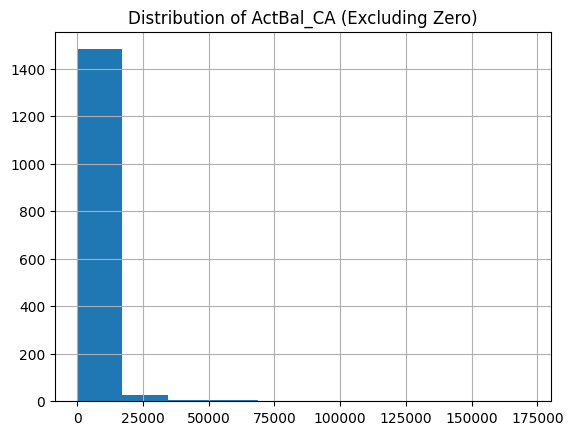

count      1521.000000
mean       2589.311068
std        7261.355965
min           0.000357
25%         104.601786
50%         564.033214
75%        2380.045714
max      171575.889600
Name: ActBal_CA, dtype: float64

ActBal_SA Feature Analysis (Excluding Zero Balances):


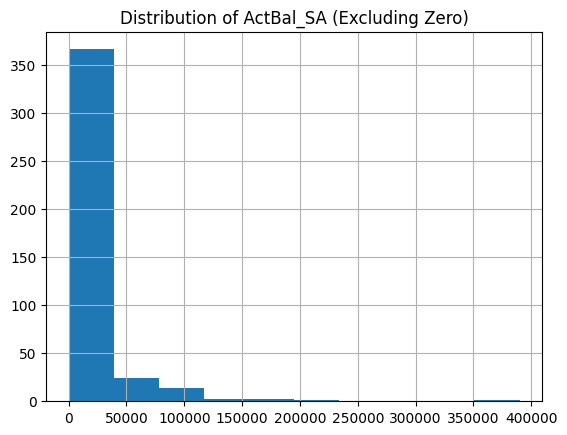

count       410.000000
mean      15794.750344
std       32849.512370
min           0.000714
25%        1073.570803
50%        5102.805893
75%       16031.414465
max      389883.830700
Name: ActBal_SA, dtype: float64

ActBal_MF Feature Analysis (Excluding Zero Balances):


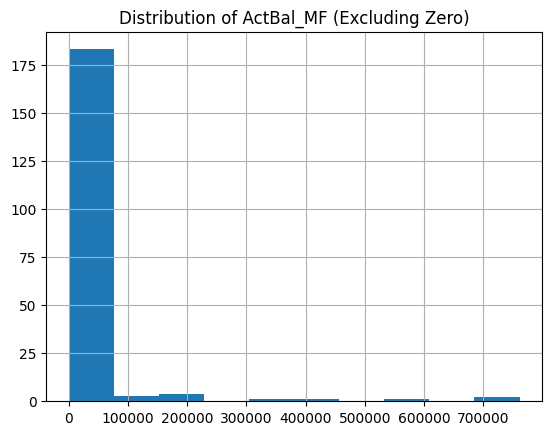

count       195.000000
mean      32196.744845
std       95909.384131
min          17.728571
25%        1953.776428
50%        7743.577143
75%       21496.285360
max      761235.504300
Name: ActBal_MF, dtype: float64

ActBal_OVD Feature Analysis (Excluding Zero Balances):


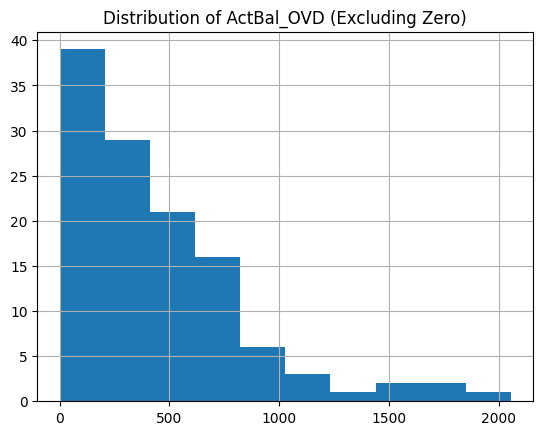

count     120.000000
mean      441.520890
std       395.347619
min         0.694643
25%       149.724643
50%       334.460714
75%       624.084464
max      2055.325357
Name: ActBal_OVD, dtype: float64

ActBal_CC Feature Analysis (Excluding Zero Balances):


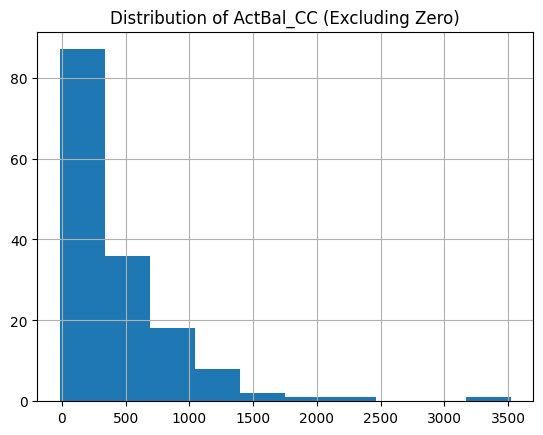

count     154.000000
mean      387.793646
std       497.373485
min       -15.479286
25%         2.347768
50%       249.714464
75%       616.642500
max      3522.233571
Name: ActBal_CC, dtype: float64

ActBal_CL Feature Analysis (Excluding Zero Balances):


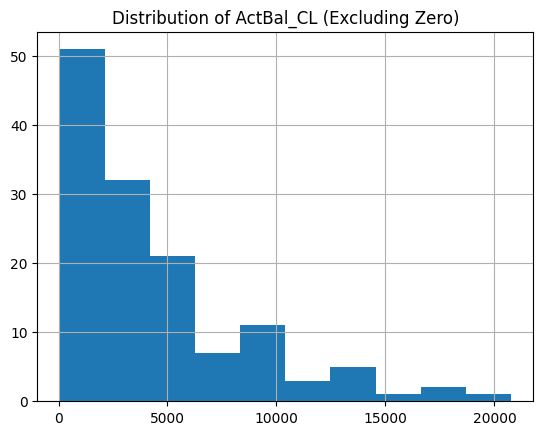

count      134.000000
mean      4269.266175
std       4166.478796
min         63.803214
25%       1043.511875
50%       3189.690000
75%       5886.812768
max      20749.294640
Name: ActBal_CL, dtype: float64


In [413]:
actbal_cols = ['ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']

# df_no_zero = df_product_actbalance.copy()
for col in actbal_cols:
    # Filter out zero balances for the current column and the associated client
    df_no_zero = df_product_actbalance[~(df_product_actbalance[col] == 0)]

    print(f"\n{col} Feature Analysis (Excluding Zero Balances):")
    df_no_zero[col].hist()
    plt.title(f"Distribution of {col} (Excluding Zero)")
    plt.show()
    print(df_no_zero[col].describe())

### <b> INSIGHT </b>
- There is a bigger skew in amount for current, savings and mutual fund accounts compared to overdraft, credit card and consumer loan. It is understandable as loans are given out upon approval by the company and the company is careful in giving out loans
- These features will have to be treated in feature engineering

## Inflow Outflow analysis

In [414]:
print("\nData Info:\n")
print(df_inflow_outflow.info())


Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Client                        1587 non-null   int64  
 1   VolumeCred                    1587 non-null   float64
 2   VolumeCred_CA                 1587 non-null   float64
 3   TransactionsCred              1587 non-null   int64  
 4   TransactionsCred_CA           1587 non-null   int64  
 5   VolumeDeb                     1587 non-null   float64
 6   VolumeDeb_CA                  1587 non-null   float64
 7   VolumeDebCash_Card            1587 non-null   float64
 8   VolumeDebCashless_Card        1587 non-null   float64
 9   VolumeDeb_PaymentOrder        1587 non-null   float64
 10  TransactionsDeb               1587 non-null   int64  
 11  TransactionsDeb_CA            1587 non-null   int64  
 12  TransactionsDebCash_Card      1587 non-null   int

In [415]:
print("\nSummary Statistics:\n")
print(df_inflow_outflow.describe(include='all'))


Summary Statistics:

            Client     VolumeCred  VolumeCred_CA  TransactionsCred  \
count  1587.000000    1587.000000    1587.000000       1587.000000   
mean    808.174543    1823.559572    1506.329113          5.541903   
std     466.744374    5864.792552    4661.535696          6.355383   
min       1.000000       0.000000       0.000000          0.000000   
25%     405.500000     252.923393     214.290893          2.000000   
50%     808.000000     655.867500     620.858214          3.000000   
75%    1213.500000    1426.027143    1304.757143          6.000000   
max    1615.000000  107703.804300   98717.675000         63.000000   

       TransactionsCred_CA      VolumeDeb  VolumeDeb_CA  VolumeDebCash_Card  \
count          1587.000000    1587.000000   1587.000000         1587.000000   
mean              4.265280    1697.218658   1460.202903          257.937337   
std               4.944032    5183.787843   4281.369956          757.734229   
min               0.000000     

In [416]:
# check for duplicated entries
duplicated_clients = df_inflow_outflow['Client'].duplicated().sum()
print(f"\nDuplicated client IDs: {duplicated_clients}")


Duplicated client IDs: 0


In [417]:
if_of_feature_cols = [
    'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA',
    'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
    'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
    'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder'
]


VolumeCred Feature Analysis:
count      1587.000000
mean       1823.559572
std        5864.792552
min           0.000000
25%         252.923393
50%         655.867500
75%        1426.027143
max      107703.804300
Name: VolumeCred, dtype: float64

VolumeCred_CA Feature Analysis:
count     1587.000000
mean      1506.329113
std       4661.535696
min          0.000000
25%        214.290893
50%        620.858214
75%       1304.757143
max      98717.675000
Name: VolumeCred_CA, dtype: float64

TransactionsCred Feature Analysis:
count    1587.000000
mean        5.541903
std         6.355383
min         0.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        63.000000
Name: TransactionsCred, dtype: float64

TransactionsCred_CA Feature Analysis:
count    1587.000000
mean        4.265280
std         4.944032
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        48.000000
Name: TransactionsCred_CA, dtype: float64

VolumeDeb Featu

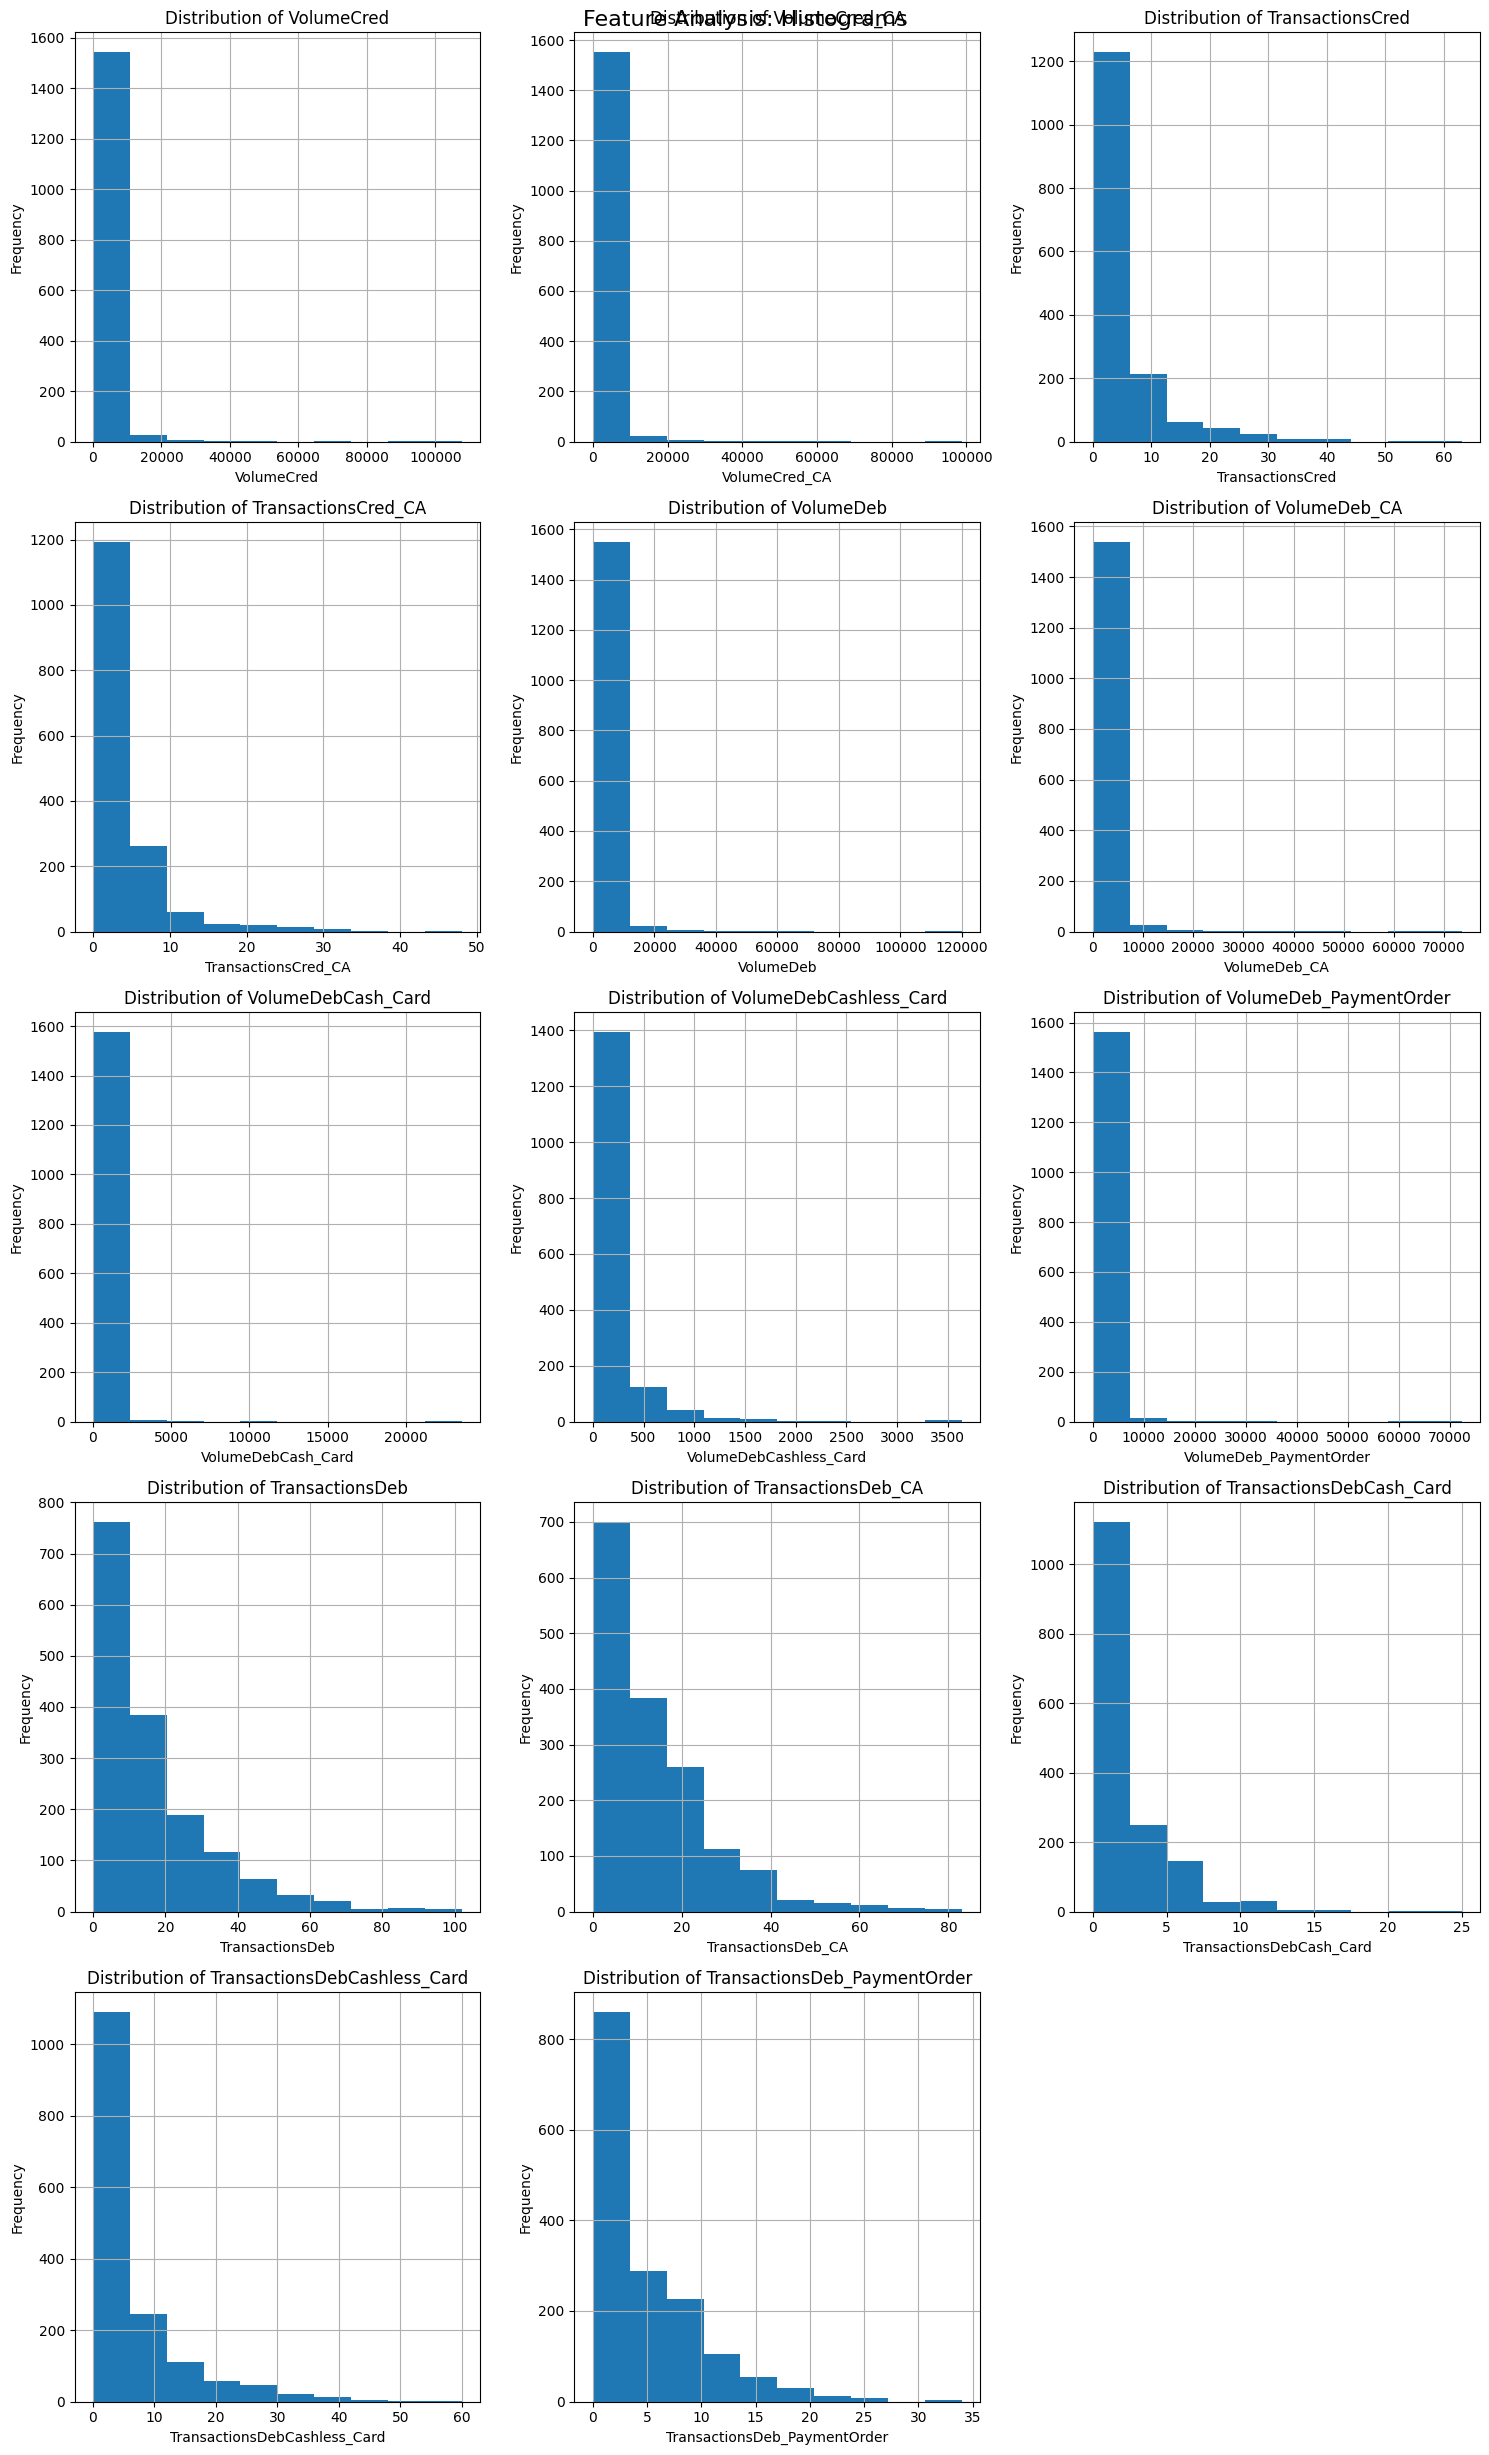

In [418]:
fig, axes = plt.subplots(5, 3, figsize=(15, 25))
fig.suptitle("Feature Analysis: Histograms", fontsize=16)

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, col in enumerate(if_of_feature_cols):
    if i < 15:  # Limit to 15 subplots (5x3 grid)
        ax = axes[i]
        df_inflow_outflow[col].hist(ax=ax)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")

        print(f"\n{col} Feature Analysis:")
        print(df_inflow_outflow[col].describe())

# Remove the last unused subplot
if len(if_of_feature_cols) < 15:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

### <b> INSIGHT </b>
- This Transactions and Volume have a natural skewed
- Treatment is necessary during modelling

In [419]:
df_inflow_outflow['VolumeCred'].sum()

2893989.040348016

In [420]:
df_inflow_outflow['VolumeCred_CA'].sum()

2390544.302513316

In [421]:
print("Checking Relationships between Transaction Counts and Volumes:")


# 1. if TransactionsDebCashless_Card = 0 then VolumeDebCashless_Card = 0
subset = df_inflow_outflow[df_inflow_outflow['TransactionsDebCashless_Card'] == 0]
inconsistent = subset[subset['VolumeDebCashless_Card'] != 0]
print(f"1. Inconsistent records for cashless debit (count=0 and Volume!=0): {len(inconsistent)}")

# 2. if TransactionsDebCash_Card = 0 then VolumeDebCash_Card = 0
subset = df_inflow_outflow[df_inflow_outflow['TransactionsDebCash_Card'] == 0]
inconsistent = subset[subset['VolumeDebCash_Card'] != 0]
print(f"2. Inconsistent records for cash debit (count=0 and Volume!=0): {len(inconsistent)}")

# 3. if TransactionsDeb_PaymentOrder = 0 then VolumeDeb_PaymentOrder = 0
subset = df_inflow_outflow[df_inflow_outflow['TransactionsDeb_PaymentOrder'] == 0]
inconsistent = subset[subset['VolumeDeb_PaymentOrder'] != 0]
print(f"3. Inconsistent records for payment order debit (count=0 and Volume!=0): {len(inconsistent)}")

# 4. if TransactionsDeb_CA = 0 then VolumeDeb_CA = 0
subset = df_inflow_outflow[df_inflow_outflow['TransactionsDeb_CA'] == 0]
inconsistent = subset[subset['VolumeDeb_CA'] != 0]
print(f"4. Inconsistent records for CA debit (count=0 and Volume!=0): {len(inconsistent)}")

# 5. if TransactionsDeb = 0 then VolumeDeb, TransactionsDeb_CA, TransactionsDebCash_Card, TransactionsDebCashless_Card, TransactionsDeb_PaymentOrder = 0
subset = df_inflow_outflow[df_inflow_outflow['TransactionsDeb'] == 0]
inconsistent = subset[(subset['VolumeDeb'] != 0) | (subset["TransactionsDeb_CA"] != 0) | (subset["TransactionsDebCash_Card"] != 0) | (subset["TransactionsDebCashless_Card"] != 0) | (subset["TransactionsDeb_PaymentOrder"] != 0) | (subset["VolumeDeb_CA"] != 0) | (subset["VolumeDebCash_Card"] != 0) | (subset["VolumeDebCashless_Card"] != 0) | (subset["VolumeDeb_PaymentOrder"] != 0)]
print(f"5. Inconsistent records for total debit (count=0 and any related volume/transaction!=0): {len(inconsistent)}")

# 6. if TransactionsCred = 0 then VolumeCred, VolumeCred_CA = 0
subset = df_inflow_outflow[df_inflow_outflow['TransactionsCred'] == 0]
inconsistent = subset[(subset['VolumeCred'] != 0) | (subset['VolumeCred_CA'] != 0)]
print(f"6. Inconsistent records for total credit (count=0 and VolumeCred or VolumeCred_CA!=0): {len(inconsistent)}")

# 7. if TransactionsCred_CA = 0 then VolumeCred_CA = 0 (but not necessarily VolumeCred)
subset = df_inflow_outflow[df_inflow_outflow['TransactionsCred_CA'] == 0]
inconsistent = subset[subset['VolumeCred_CA'] != 0]
print(f"7. Inconsistent records for CA credit (count=0 and VolumeCred_CA!=0): {len(inconsistent)}")

Checking Relationships between Transaction Counts and Volumes:
1. Inconsistent records for cashless debit (count=0 and Volume!=0): 0
2. Inconsistent records for cash debit (count=0 and Volume!=0): 0
3. Inconsistent records for payment order debit (count=0 and Volume!=0): 0
4. Inconsistent records for CA debit (count=0 and Volume!=0): 0
5. Inconsistent records for total debit (count=0 and any related volume/transaction!=0): 0
6. Inconsistent records for total credit (count=0 and VolumeCred or VolumeCred_CA!=0): 0
7. Inconsistent records for CA credit (count=0 and VolumeCred_CA!=0): 0


<b> Assumption : </b> TransactionsDeb should be a sum of TransactionsDeb_CA, TransactionsDebCash_Card, TransactionsDebCashless_Card and TransactionsDeb_PaymentOrder. Same for Volume as well, and same logic should apply for Credit transactions too. Let us see if this is the case

In [422]:
# Debit transactions check
df_inflow_outflow['calculated_transactions_deb'] = df_inflow_outflow['TransactionsDeb_CA'] + df_inflow_outflow['TransactionsDebCash_Card'] + df_inflow_outflow['TransactionsDebCashless_Card'] + df_inflow_outflow['TransactionsDeb_PaymentOrder']
df_inflow_outflow['debit_difference'] = df_inflow_outflow['TransactionsDeb'] - df_inflow_outflow['calculated_transactions_deb']

# Select clients with non-zero debit difference
inconsistent_debit_transactions = df_inflow_outflow[df_inflow_outflow['debit_difference'] != 0]['Client'].unique()
print(f"Number of unique clients with a debit difference: {len(inconsistent_debit_transactions)}")

Number of unique clients with a debit difference: 1373


In [423]:
# Credit transactions check
df_inflow_outflow['credit_difference'] = df_inflow_outflow['TransactionsCred'] - df_inflow_outflow['TransactionsCred_CA']
# Select clients with non-zero debit difference
inconsistent_credit_transactions = df_inflow_outflow[df_inflow_outflow['credit_difference'] != 0]['Client'].unique()
print(f"Number of unique clients with a credit difference: {len(inconsistent_credit_transactions)}")

Number of unique clients with a credit difference: 695


### <b>INSIGT</b>
- The assumption that total debit transactions are a sum of transactions of Deb_CA, DebCash_Card, DebCashless_Card and Deb_PaymentOrder is not validated.
- Same with the credit transactions and volume for debit/credit too
- More information about the data is needed. There could be missing values or data collection/aggregation errors

In [424]:
# Create a dictionary with transaction and volume columns
transaction_volume_pairs = {
    'TransactionsCred': 'VolumeCred',
    'TransactionsCred_CA': 'VolumeCred_CA',
    'TransactionsDeb': 'VolumeDeb',
    'TransactionsDeb_CA': 'VolumeDeb_CA',
    'TransactionsDebCash_Card': 'VolumeDebCash_Card',
    'TransactionsDebCashless_Card': 'VolumeDebCashless_Card',
    'TransactionsDeb_PaymentOrder': 'VolumeDeb_PaymentOrder'
}

In [425]:
# create new variables
for transaction_col, volume_col in transaction_volume_pairs.items():
    new_col = f'volume_per_transaction_{transaction_col.replace("Transactions","").lower()}'
    df_inflow_outflow[new_col] = df_inflow_outflow[volume_col] / (df_inflow_outflow[transaction_col] + 1e-6)

In [426]:
df_inflow_outflow.columns

Index(['Client', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred',
       'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'calculated_transactions_deb',
       'debit_difference', 'credit_difference', 'volume_per_transaction_cred',
       'volume_per_transaction_cred_ca', 'volume_per_transaction_deb',
       'volume_per_transaction_deb_ca', 'volume_per_transaction_debcash_card',
       'volume_per_transaction_debcashless_card',
       'volume_per_transaction_deb_paymentorder'],
      dtype='object')

In [427]:
corr_variables_to_check = ['VolumeCred', 'VolumeCred_CA', 'TransactionsCred',
       'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder',
       'volume_per_transaction_cred', 'volume_per_transaction_cred_ca',
       'volume_per_transaction_deb', 'volume_per_transaction_deb_ca',
       'volume_per_transaction_debcash_card',
       'volume_per_transaction_debcashless_card',
       'volume_per_transaction_deb_paymentorder'
       ]

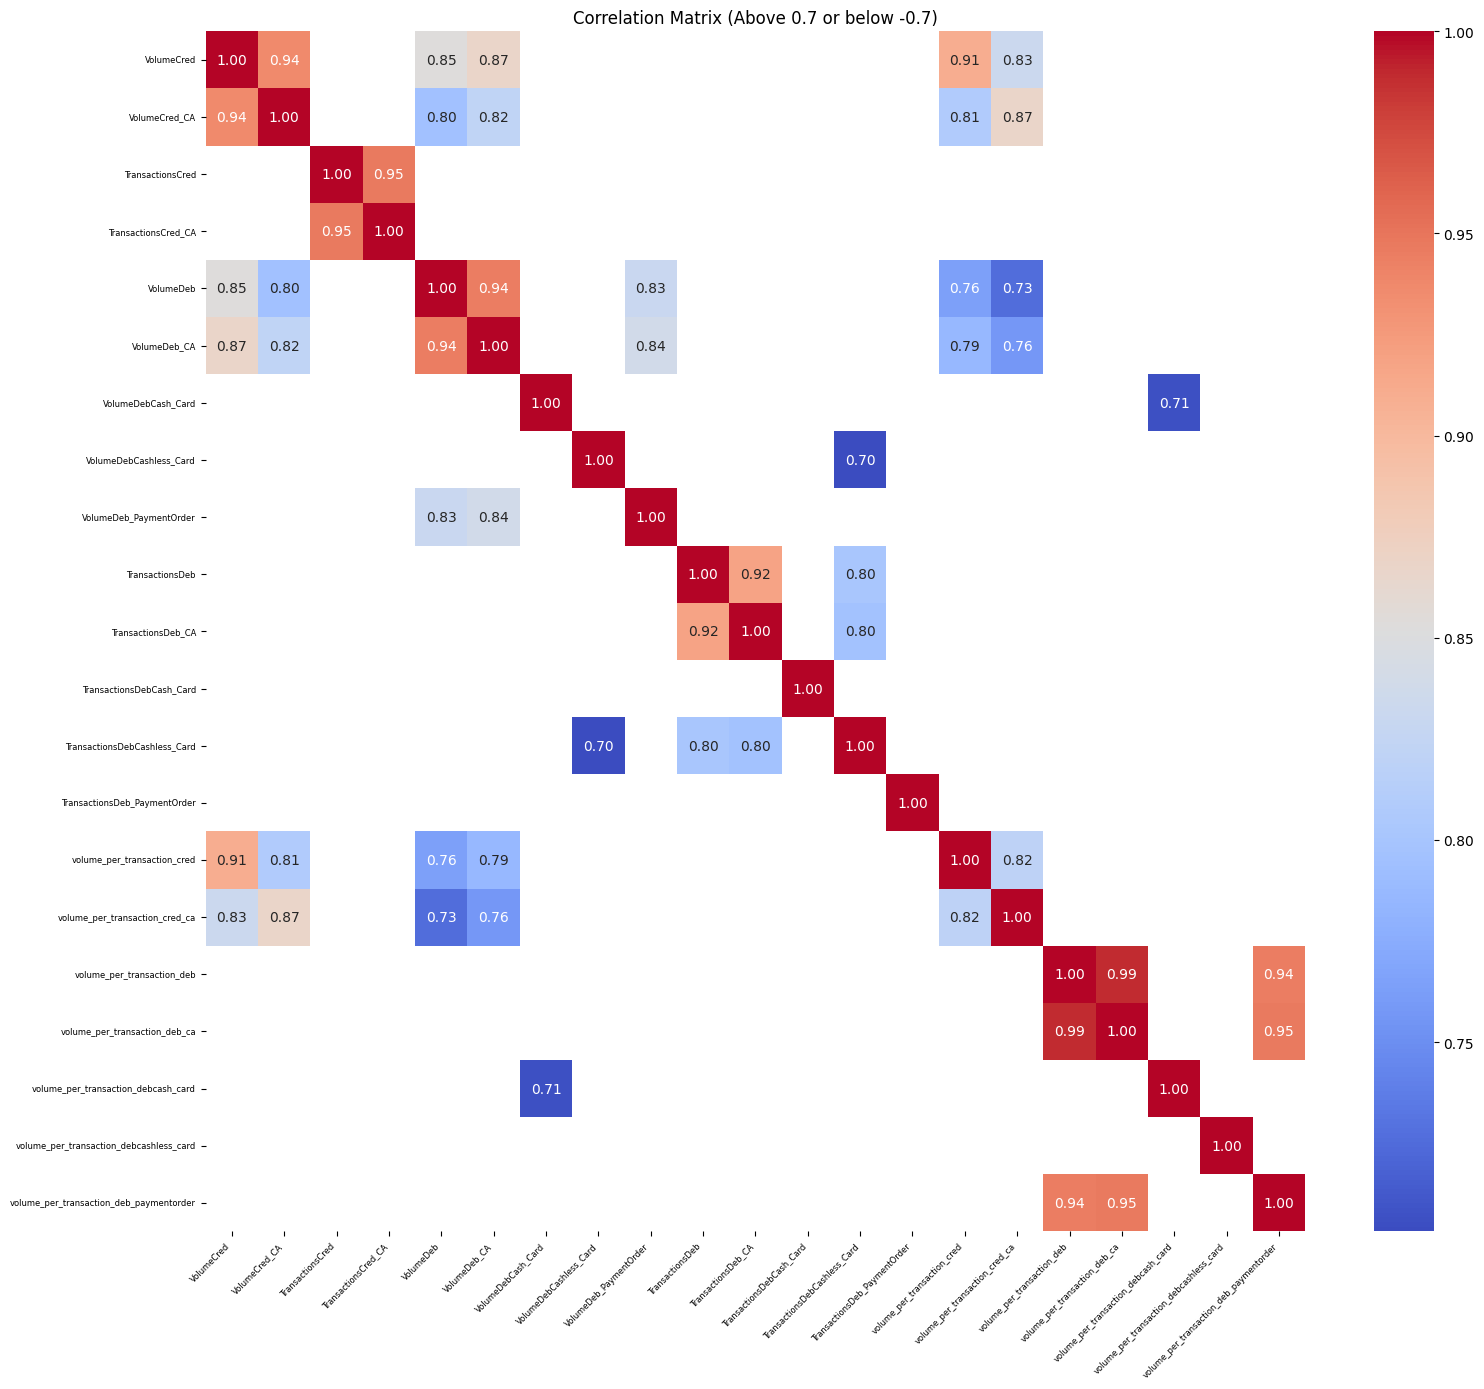

In [428]:
# Calculate the correlation matrix
corr_matrix = df_inflow_outflow[corr_variables_to_check].corr()

# Create a mask for correlations below 0.7
mask = (abs(corr_matrix) < 0.7)

# Create a heatmap with mask
plt.figure(figsize=(16, 14))  # Adjust the figure size for better readability
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", mask=mask)
plt.title('Correlation Matrix (Above 0.7 or below -0.7)')

# Adjust label size
plt.xticks(fontsize=6, rotation=45, ha="right")  # Adjust rotation for better label spacing
plt.yticks(fontsize=6)

plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.show()

### <b> INSIGHT </b>
- Strong correlations exist, and they should be treated during modelling
- Highest correlation was observed between volume_per_transaction_deb_ca and volume_per_transaction_deb
- Overall, 8 correlations have value above 0.9

## Sales Revenue Analysis

In [429]:
print("\nData Info:\n")
print(df_sales_revenues.info())


Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Client      969 non-null    int64  
 1   Sale_MF     969 non-null    int64  
 2   Sale_CC     969 non-null    int64  
 3   Sale_CL     969 non-null    int64  
 4   Revenue_MF  969 non-null    float64
 5   Revenue_CC  969 non-null    float64
 6   Revenue_CL  969 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 53.1 KB
None


In [430]:
print("\nSummary Statistics:\n")
print(df_sales_revenues.describe(include='all'))


Summary Statistics:

            Client     Sale_MF     Sale_CC     Sale_CL  Revenue_MF  \
count   969.000000  969.000000  969.000000  969.000000  969.000000   
mean    814.781218    0.199174    0.249742    0.299278    1.925015   
std     464.568139    0.399586    0.433087    0.458178    9.943601   
min       1.000000    0.000000    0.000000    0.000000    0.000000   
25%     422.000000    0.000000    0.000000    0.000000    0.000000   
50%     819.000000    0.000000    0.000000    0.000000    0.000000   
75%    1216.000000    0.000000    0.000000    1.000000    0.000000   
max    1615.000000    1.000000    1.000000    1.000000  220.488214   

       Revenue_CC  Revenue_CL  
count  969.000000  969.000000  
mean     2.712827    3.604220  
std     17.693433    7.743618  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    0.000000  
75%      0.000000    4.642857  
max    407.962500  133.275357  


In [431]:
# check for duplicated entries
duplicated_clients = df_sales_revenues['Client'].duplicated().sum()
print(f"\nDuplicated client IDs: {duplicated_clients}")


Duplicated client IDs: 0


In [432]:
product_types = {
    'MF': ['Sale_MF', 'Revenue_MF'],
    'CC': ['Sale_CC', 'Revenue_CC'],
    'CL': ['Sale_CL', 'Revenue_CL']
}


--- MF Analysis ---

Sale_MF Analysis:
Value Counts:
Sale_MF
0    776
1    193
Name: count, dtype: int64

Revenue_MF Feature Analysis:

--- CC Analysis ---

Sale_CC Analysis:
Value Counts:
Sale_CC
0    727
1    242
Name: count, dtype: int64

Revenue_CC Feature Analysis:

--- CL Analysis ---

Sale_CL Analysis:
Value Counts:
Sale_CL
0    679
1    290
Name: count, dtype: int64

Revenue_CL Feature Analysis:


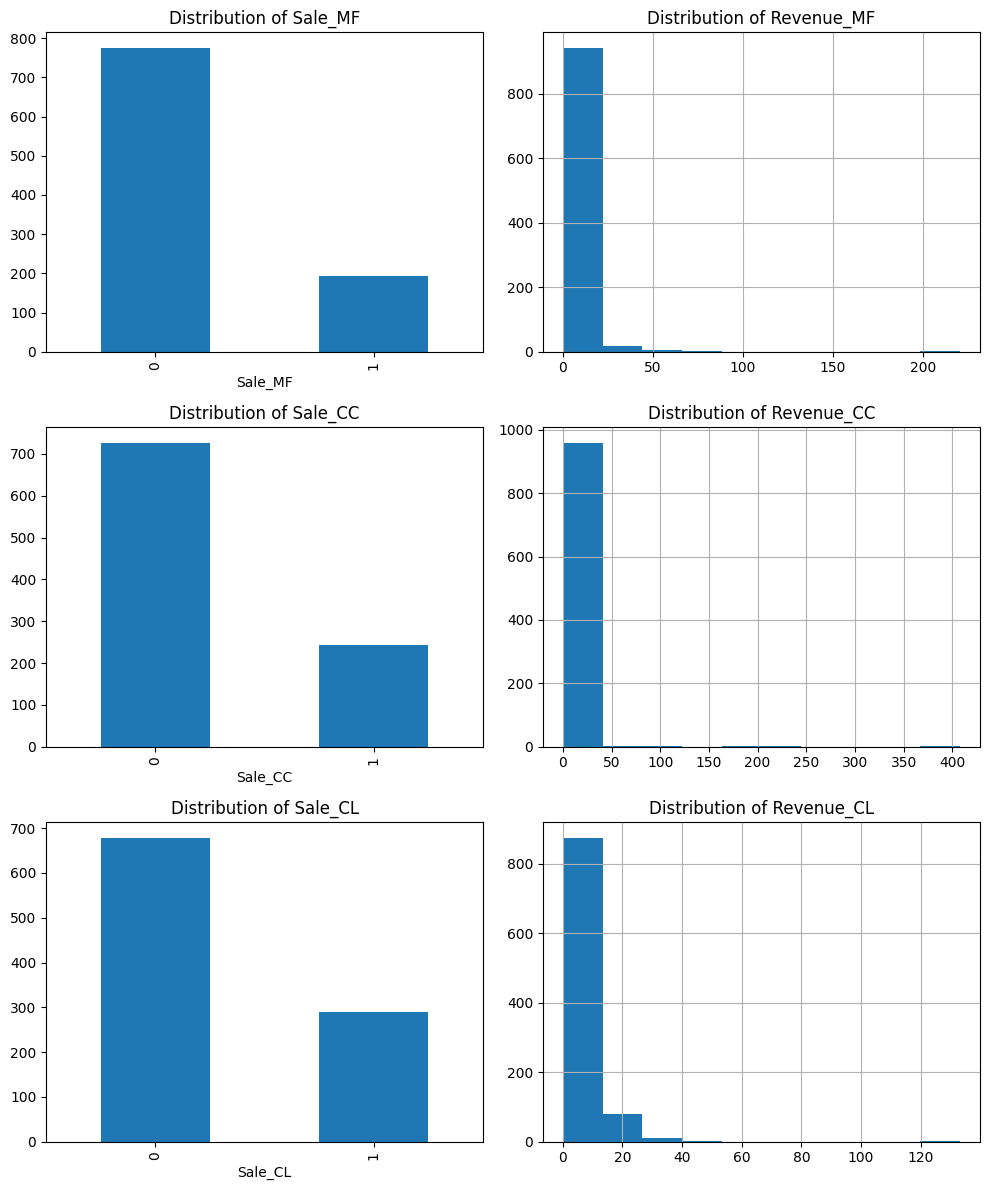

In [433]:
# Set up the overall figure
plt.figure(figsize=(10, 4 * len(product_types)))

for i, (product, cols) in enumerate(product_types.items()):
    sale_col, revenue_col = cols
    print(f"\n--- {product} Analysis ---")

    # Create a subplot for each product (2 rows, 2 columns)
    plt.subplot(len(product_types), 2, 2*i + 1)

    # Plot for sales variable
    print(f"\n{sale_col} Analysis:")
    print(f"Value Counts:\n{df_sales_revenues[sale_col].value_counts()}")
    df_sales_revenues[sale_col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {sale_col}')
    plt.tight_layout()

    # Plot for revenue variable
    plt.subplot(len(product_types), 2, 2*i + 2)
    print(f"\n{revenue_col} Feature Analysis:")
    df_sales_revenues[revenue_col].hist()
    plt.title(f"Distribution of {revenue_col}")
    plt.tight_layout()

# Adjust layout and display all plots
plt.tight_layout()
plt.show()

### <b> INSIGHT </b>
- Distribution of Revenue is skewed. The company makes most of it's revenue from small ticket sizes

In [434]:
print(f"Count of Clients having a MF are {df_sales_revenues['Sale_MF'].sum()} and revenue total generated was {df_sales_revenues['Revenue_MF'].sum()}")
print(f"MF Revenue per client is {df_sales_revenues['Revenue_MF'].sum() / df_sales_revenues['Sale_MF'].sum()}")


Count of Clients having a MF are 193 and revenue total generated was 1865.3400000030001
MF Revenue per client is 9.664974093279794


In [435]:
print(f"Count of Clients having a CC are {df_sales_revenues['Sale_CC'].sum()} and revenue total generated was {df_sales_revenues['Revenue_CC'].sum()}")
print(f"MF Revenue per client is {df_sales_revenues['Revenue_CC'].sum() / df_sales_revenues['Sale_CC'].sum()}")

Count of Clients having a CC are 242 and revenue total generated was 2628.7289285770003
MF Revenue per client is 10.862516233789258


In [436]:
print(f"Count of Clients having a CL are {df_sales_revenues['Sale_CL'].sum()} and revenue total generated was {df_sales_revenues['Revenue_CL'].sum()}")
print(f"MF Revenue per client is {df_sales_revenues['Revenue_CL'].sum() / df_sales_revenues['Sale_CL'].sum()}")

Count of Clients having a CL are 290 and revenue total generated was 3492.489285724
MF Revenue per client is 12.043066502496552


### <b> INSIGHT </b>
- Highest revenue and revenue per client was generated by Consumer Loan product

# Data Pre-processing

- Create flags for situations where product exists but balance is 0

In [437]:
for count_col, balance_col in product_pairs.items():
    new_col_name = f"has_count_but_zero_bal_{count_col.replace('Count_','').lower()}"
    df_product_actbalance[new_col_name] = ((df_product_actbalance[count_col] >= 1) & (df_product_actbalance[balance_col] == 0)).astype(int)

In [438]:
df_product_actbalance.head()

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,has_count_but_zero_bal_ca,has_count_but_zero_bal_sa,has_count_but_zero_bal_mf,has_count_but_zero_bal_ovd,has_count_but_zero_bal_cc,has_count_but_zero_bal_cl
0,1,1,NaN,NaN,1.0,NaN,NaN,1333.802857,NaN,NaN,0.0,NaN,NaN,0,0,0,1,0,0
1,2,1,1.0,NaN,NaN,NaN,NaN,110.768571,13326.190360,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,3,1,NaN,1.0,NaN,NaN,NaN,482.654643,NaN,107.251786,NaN,NaN,NaN,0,0,0,0,0,0
3,4,1,1.0,NaN,NaN,1.0,NaN,1599.840714,76.437143,NaN,NaN,1110.381786,NaN,0,0,0,0,0,0
4,5,1,1.0,NaN,NaN,NaN,NaN,5353.483929,8079.715714,NaN,NaN,NaN,NaN,0,0,0,0,0,0


## Merge all dataframes

In [440]:
# make sure all dataframes have no duplicate client IDs so that merging does not yeild duplicate values
def find_duplicate_client_ids(df):
  if 'Client' not in df.columns:
        print("Warning: 'Client' column not found in the dataframe")
        return []

  duplicate_mask = df['Client'].duplicated(keep=False)
  duplicate_clients = df.loc[duplicate_mask, 'Client']
  unique_duplicates = duplicate_clients.unique().tolist()
  total_duplicates = len(duplicate_clients) - len(unique_duplicates)

  return total_duplicates, unique_duplicates


for df_name, df in [("df_social_dem", df_social_dem),
                  ("df_product_actbalance", df_product_actbalance),
                  ("df_inflow_outflow", df_inflow_outflow),
                  ("df_sales_revenues", df_sales_revenues)]:
  dup_count, dup_clients = find_duplicate_client_ids(df)
  print(f"\nDuplicates in {df_name}:")
  print(f"Total duplicate entries: {dup_count}")
  print(f"Duplicate Client IDs: {dup_clients}")


Duplicates in df_social_dem:
Total duplicate entries: 0
Duplicate Client IDs: []

Duplicates in df_product_actbalance:
Total duplicate entries: 0
Duplicate Client IDs: []

Duplicates in df_inflow_outflow:
Total duplicate entries: 0
Duplicate Client IDs: []

Duplicates in df_sales_revenues:
Total duplicate entries: 0
Duplicate Client IDs: []


In [441]:
# Check if clients in all other dataframes exist in social_dem
def check_clients_exist_in_social_dem(df_social_dem, df):
    """
    Check if clients in the given dataframe exist in df_social_dem.

    Args:
    df_social_dem (pandas.DataFrame): The social demographics dataframe
    df (pandas.DataFrame): The dataframe to check against df_social_dem

    Returns:
    list: A list of client IDs that are in df but not in df_social_dem
    """
    if 'Client' not in df.columns:
        print("Warning: 'Client' column not found in the dataframe")
        return []

    social_dem_clients = set(df_social_dem['Client'])
    df_clients = set(df['Client'])

    missing_clients = list(df_clients - social_dem_clients)

    return missing_clients

dfs_to_check = {
    "df_product_actbalance": df_product_actbalance,
    "df_inflow_outflow": df_inflow_outflow,
    "df_sales_revenues": df_sales_revenues
}

for df_name, df in dfs_to_check.items():
    missing_clients = check_clients_exist_in_social_dem(df_social_dem, df)
    print(f"\nClients in {df_name} not found in df_social_dem:")
    if missing_clients:
        for client in missing_clients:
            print(client)
    else:
        print("All clients exist in df_social_dem")


Clients in df_product_actbalance not found in df_social_dem:
All clients exist in df_social_dem

Clients in df_inflow_outflow not found in df_social_dem:
All clients exist in df_social_dem

Clients in df_sales_revenues not found in df_social_dem:
All clients exist in df_social_dem


#### Assumption for inactive clients
- Assuming df_inflow_outflow was generated from the dates qualified as "active" period, if there were no transactions for a client it would mean that the client was not active during the period and hence marketing should not target these clients.

Let us test this hypothesis

In [442]:
# Create a set of all clients that have at least one current account
clients_list = set(df_product_actbalance['Client'])

# Get the set of clients with transactions
clients_with_transactions = set(df_inflow_outflow['Client'])

# Identify clients with current accounts but no transactions
inactive_clients = clients_list.difference(clients_with_transactions)
print(f"Number of inactive clients are {len(inactive_clients)} or {100* len(inactive_clients) / len(clients_list):.2f}% of total clients")

# Create DataFrame from the inactive clients set
inactive_clients_df = pd.DataFrame({'Client': list(inactive_clients)})

Number of inactive clients are 28 or 1.73% of total clients


In [443]:
# Merge inactive clients DataFrame with sales revenue DataFrame
merged_inactive_sales = pd.merge(inactive_clients_df, df_sales_revenues, on='Client', how='left')

# Check for non-zero sales or revenue for inactive clients
inactive_with_sales = merged_inactive_sales[
    (merged_inactive_sales['Sale_MF'] > 0) |
    (merged_inactive_sales['Revenue_MF'] > 0) |
    (merged_inactive_sales['Sale_CC'] > 0) |
    (merged_inactive_sales['Revenue_CC'] > 0) |
    (merged_inactive_sales['Sale_CL'] > 0) |
    (merged_inactive_sales['Revenue_CL'] > 0)
]

print(f"Number of inactive clients with sales or revenue: {len(inactive_with_sales)}")
# inactive_with_sales

Number of inactive clients with sales or revenue: 6


In [444]:
inactive_with_sales

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
8,941,0.0,0.0,1.0,0.0,0.000000,19.75
9,1199,0.0,1.0,0.0,0.0,5.892857,0.00
15,833,0.0,1.0,0.0,0.0,4.999286,0.00
17,334,0.0,1.0,0.0,0.0,1.786786,0.00
22,741,0.0,1.0,0.0,0.0,8.934286,0.00
24,1141,0.0,1.0,0.0,0.0,4.035714,0.00


- Assumption disproved. 6 out of 28 clients generated revenue for the company

In [445]:
# Merge dataframes using left join
merged_df = df_social_dem.copy()
merged_df = pd.merge(merged_df, df_product_actbalance, on='Client', how='left')
merged_df = pd.merge(merged_df, df_inflow_outflow, on='Client', how='left')
merged_df = pd.merge(merged_df, df_sales_revenues, on='Client', how='left')


In [446]:
print("Merged DataFrame shape:", merged_df.shape)

Merged DataFrame shape: (1615, 52)


In [447]:
# Find columns with missing values
null_counts = merged_df.isnull().sum()
columns_with_missing = null_counts[null_counts > 0]


# Print columns with missing values and their counts
print("Columns with Missing Value Counts ( > 0):\n")
print(columns_with_missing)

Columns with Missing Value Counts ( > 0):

Sex                                           3
Count_SA                                   1189
Count_MF                                   1309
Count_OVD                                  1196
Count_CC                                   1445
Count_CL                                   1480
ActBal_SA                                  1189
ActBal_MF                                  1309
ActBal_OVD                                 1196
ActBal_CC                                  1445
ActBal_CL                                  1480
VolumeCred                                   28
VolumeCred_CA                                28
TransactionsCred                             28
TransactionsCred_CA                          28
VolumeDeb                                    28
VolumeDeb_CA                                 28
VolumeDebCash_Card                           28
VolumeDebCashless_Card                       28
VolumeDeb_PaymentOrder                       

In [448]:
# Impute gender with mode
merged_df['Sex'] = merged_df['Sex'].fillna(merged_df['Sex'].mode()[0])
print(f"NULLs in Sex after imputation : {merged_df['Sex'].isnull().sum()}")

NULLs in Sex after imputation : 0


In [449]:
merged_df['total_revenue'] = merged_df['Revenue_MF'] + merged_df['Revenue_CC'] + merged_df['Revenue_CL']

In [450]:
merged_df.columns

Index(['Client', 'Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL',
       'has_count_but_zero_bal_ca', 'has_count_but_zero_bal_sa',
       'has_count_but_zero_bal_mf', 'has_count_but_zero_bal_ovd',
       'has_count_but_zero_bal_cc', 'has_count_but_zero_bal_cl', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'calculated_transactions_deb',
       'debit_difference', 'credit_difference', 'volume_per_transaction_cred',
       'volume_per_transaction_cred_ca', 'volume_per_transaction_deb',
       'volume_per_transaction_deb_ca', 'volume_per_transaction_debcash

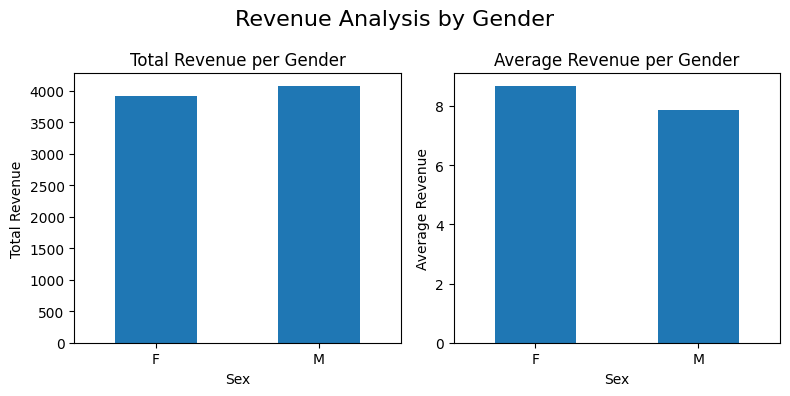


Total Revenue per Gender:
Sex
F    3916.947500
M    4069.610714
Name: total_revenue, dtype: float64

Average Revenue per Gender:
Sex
F    8.665813
M    7.871587
Name: total_revenue, dtype: float64


In [451]:
# Calculate sum and average of revenue by gender
revenue_sum_by_gender = merged_df.groupby("Sex")['total_revenue'].sum()
revenue_avg_by_gender = merged_df.groupby("Sex")['total_revenue'].mean()

# Create a figure with two subplots in a 1x2 grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Revenue Analysis by Gender", fontsize=16)

# Plot sum of revenue
revenue_sum_by_gender.plot(kind="bar", ax=ax1)
ax1.set_title("Total Revenue per Gender")
ax1.set_ylabel("Total Revenue")
ax1.tick_params(axis='x', rotation=0)

# Plot average revenue
revenue_avg_by_gender.plot(kind="bar", ax=ax2)
ax2.set_title("Average Revenue per Gender")
ax2.set_ylabel("Average Revenue")
ax2.tick_params(axis='x', rotation=0)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the results
print("\nTotal Revenue per Gender:")
print(revenue_sum_by_gender)
print("\nAverage Revenue per Gender:")
print(revenue_avg_by_gender)

- Average revenue for Males is lesser than females, although the total revenue by Males is higher

<ipython-input-452-493f29b81b63>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_total = merged_df.groupby(['age_group', 'Sex'])['total_revenue'].sum().unstack()
<ipython-input-452-493f29b81b63>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_avg = merged_df.groupby(['age_group', 'Sex'])['total_revenue'].mean().unstack()


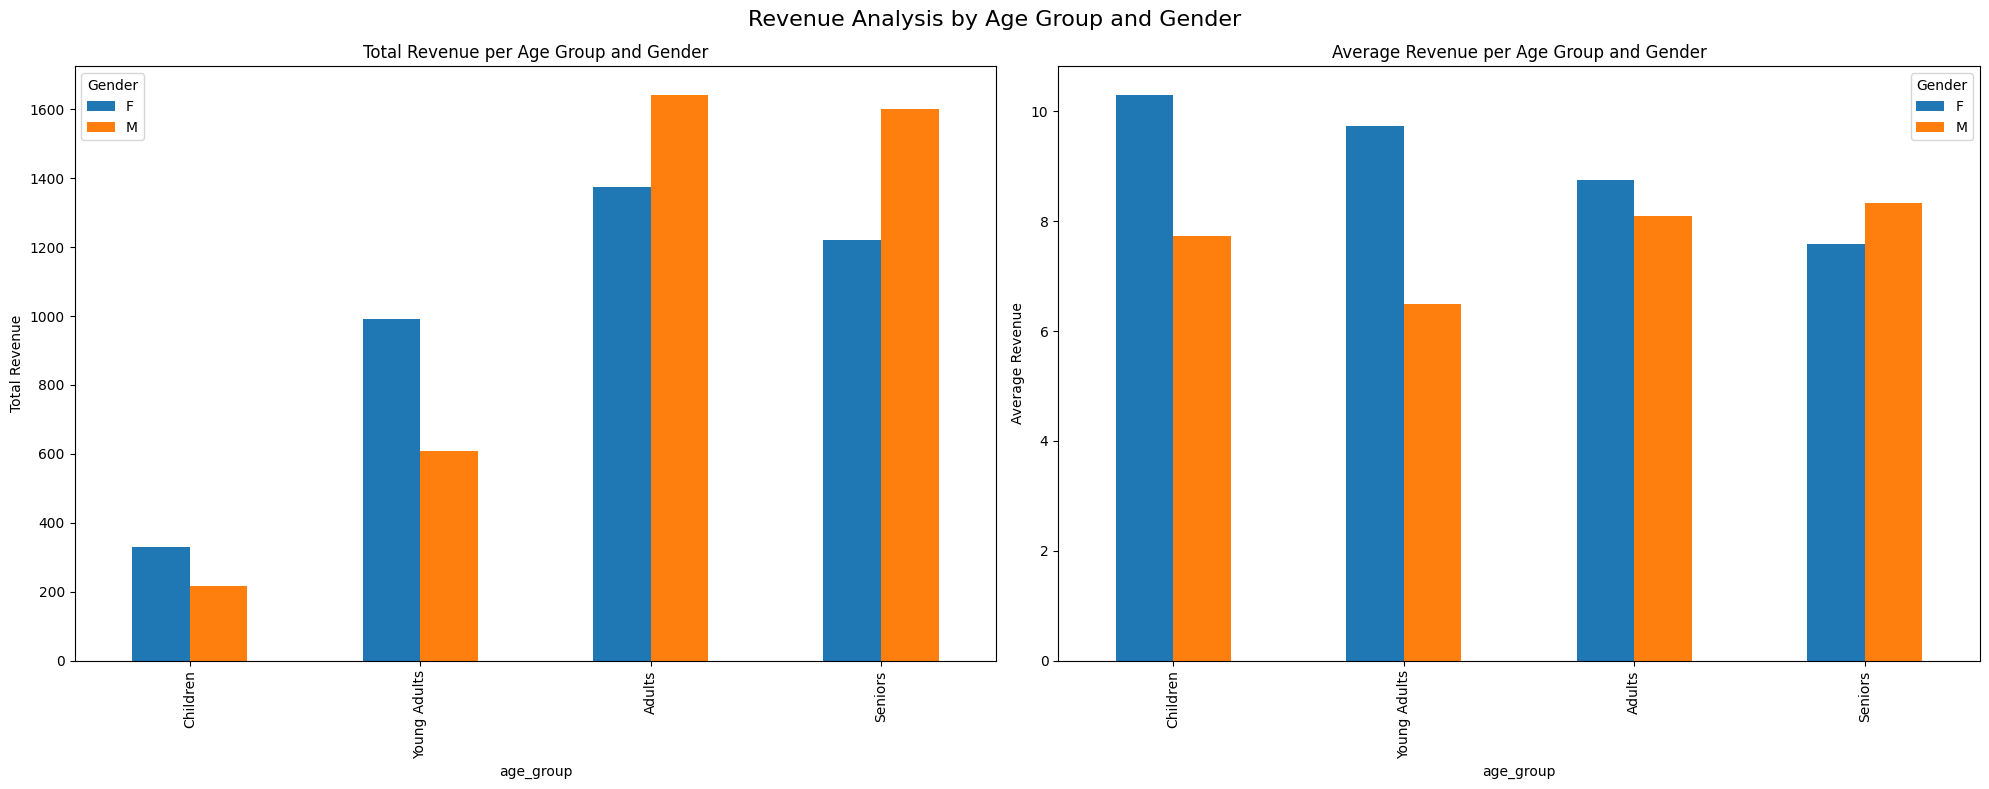


Total Revenue per Age Group and Gender:
Sex                     F            M
age_group                             
Children       329.709643   216.646786
Young Adults   992.261071   609.836071
Adults        1373.384464  1642.794821
Seniors       1221.592321  1600.333036

Average Revenue per Age Group and Gender:
Sex                   F         M
age_group                        
Children      10.303426  7.737385
Young Adults   9.728050  6.487618
Adults         8.747672  8.092585
Seniors        7.587530  8.335068


In [452]:
# Create age groups
bins = [0, 18, 30, 50, 100]
labels = ['Children', 'Young Adults', 'Adults', 'Seniors']
merged_df['age_group'] = pd.cut(merged_df['Age'], bins=bins, labels=labels, right=False)

# Calculate total and average revenue by age group and sex
revenue_total = merged_df.groupby(['age_group', 'Sex'])['total_revenue'].sum().unstack()
revenue_avg = merged_df.groupby(['age_group', 'Sex'])['total_revenue'].mean().unstack()

# Create a figure with two subplots in a 1x2 grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Revenue Analysis by Age Group and Gender", fontsize=16)

# Plot total revenue
revenue_total.plot(kind='bar', ax=ax1)
ax1.set_title("Total Revenue per Age Group and Gender")
ax1.set_ylabel("Total Revenue")
ax1.legend(title="Gender")

# Plot average revenue
revenue_avg.plot(kind='bar', ax=ax2)
ax2.set_title("Average Revenue per Age Group and Gender")
ax2.set_ylabel("Average Revenue")
ax2.legend(title="Gender")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the results
print("\nTotal Revenue per Age Group and Gender:")
print(revenue_total)
print("\nAverage Revenue per Age Group and Gender:")
print(revenue_avg)

- Interesting insight. Young Females (<30 years of age) are generating more total revenue as compared to males. Average revenue per client is higher for only Senior males compared to females in other age groups

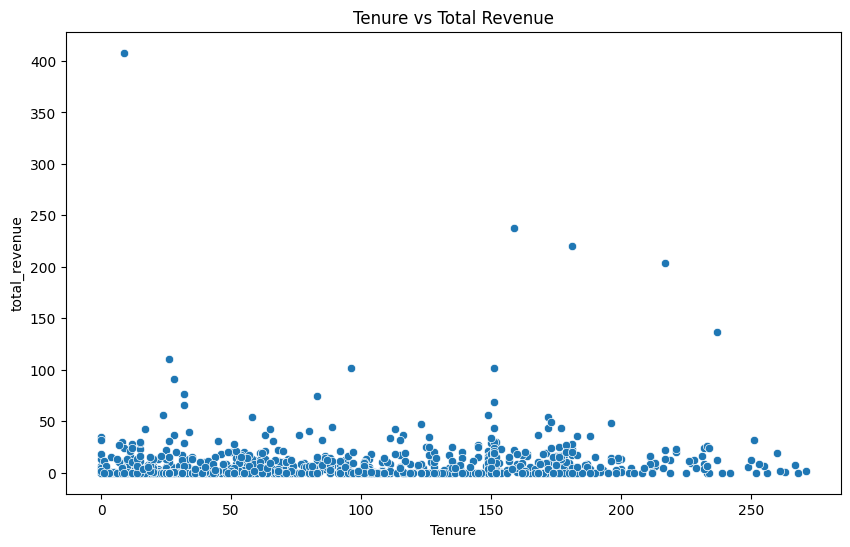

In [453]:
# Scatterplot of tenure vs total revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Tenure", y="total_revenue", data=merged_df)
plt.title("Tenure vs Total Revenue")
plt.show()

- Higher tenure does not translate to higher total revenue from the client.

# Feature Engineering

In [454]:
merged_df['total_products'] = merged_df['Count_CA'] + merged_df['Count_SA'] + merged_df['Count_MF'] + merged_df['Count_OVD'] + merged_df['Count_CC'] + merged_df['Count_CL']
merged_df['total_asset_products'] = merged_df['Count_CA'] + merged_df['Count_SA'] + merged_df['Count_MF']
merged_df['total_liabilities_products'] = merged_df['Count_OVD'] + merged_df['Count_CC'] + merged_df['Count_CL']

merged_df['asset_balance'] = merged_df['ActBal_CA'] + merged_df['ActBal_SA'] + merged_df['ActBal_MF']
merged_df['liabilities_balance'] = merged_df['ActBal_OVD'] + merged_df['ActBal_CC'] + merged_df['ActBal_CL']
merged_df['net_balance'] = merged_df['asset_balance'] - merged_df['liabilities_balance']

In [455]:
merged_df['Credit_Debit_Ratio'] = merged_df['VolumeCred'] / (merged_df['VolumeDeb'] + 1e-6) #Adding a small number to avoid division by zero
merged_df['Cash_Card_Ratio'] = merged_df['VolumeDebCash_Card'] / (merged_df['VolumeDebCashless_Card'] + 1e-6)

merged_df['Transactions_Ratio'] = merged_df['TransactionsCred'] / (merged_df['TransactionsDeb'] + 1e-6)

merged_df['CA_Transactions_Ratio'] = merged_df['TransactionsCred_CA'] / (merged_df['TransactionsDeb_CA'] + 1e-6)
merged_df['PaymentOrder_Ratio'] = merged_df['VolumeDeb_PaymentOrder'] / (merged_df['VolumeDeb'] + 1e-6)

In [456]:
# Identify numeric columns with missing values
numeric_cols_with_na = merged_df.select_dtypes(include=np.number).columns[merged_df.select_dtypes(include=np.number).isnull().any()]

# Fill NaN values in numeric columns with 0
for col in numeric_cols_with_na:
    merged_df[col] = merged_df[col].fillna(0)

In [457]:
# Exclude specified columns from imputation
exclude_cols = ['Client', 'Sex', 'Age', 'Tenure']

# Iterate through columns and impute missing values with 0
for column in merged_df.columns:
    if column not in exclude_cols and pd.api.types.is_numeric_dtype(merged_df[column]):
        merged_df[column] = merged_df[column].fillna(0)

In [458]:
null_counts = merged_df.isnull().sum()
columns_with_missing = null_counts[null_counts > 0]
print("Columns with Missing Value Counts ( > 0):\n")
columns_with_missing

Columns with Missing Value Counts ( > 0):



,0


In [459]:
merged_df = merged_df.drop(columns=['age_group']) # drop as we will be using the actual age in modelling

In [460]:
merged_df = pd.get_dummies(merged_df, columns=['Sex'], drop_first=True)

In [461]:
merged_df.columns

Index(['Client', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL',
       'has_count_but_zero_bal_ca', 'has_count_but_zero_bal_sa',
       'has_count_but_zero_bal_mf', 'has_count_but_zero_bal_ovd',
       'has_count_but_zero_bal_cc', 'has_count_but_zero_bal_cl', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'calculated_transactions_deb',
       'debit_difference', 'credit_difference', 'volume_per_transaction_cred',
       'volume_per_transaction_cred_ca', 'volume_per_transaction_deb',
       'volume_per_transaction_deb_ca', 'volume_per_transaction_debcash_card',

### variables

In [462]:
id_var = ['Client']
dummy_vars = ['has_count_but_zero_bal_ca', 'has_count_but_zero_bal_sa',
       'has_count_but_zero_bal_mf', 'has_count_but_zero_bal_ovd',
       'has_count_but_zero_bal_cc', 'has_count_but_zero_bal_cl', 'Sex_M']
# cat_vars = ['Sex']
num_vars = ['Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'calculated_transactions_deb',
       'debit_difference', 'credit_difference', 'volume_per_transaction_cred',
       'volume_per_transaction_cred_ca', 'volume_per_transaction_deb',
       'volume_per_transaction_deb_ca', 'volume_per_transaction_debcash_card',
       'volume_per_transaction_debcashless_card',
       'volume_per_transaction_deb_paymentorder', 'Sale_MF', 'Sale_CC',
       'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL', 'total_revenue',
       'total_products', 'total_asset_products', 'total_liabilities_products',
       'asset_balance', 'liabilities_balance', 'net_balance', 'Credit_Debit_Ratio', 'Cash_Card_Ratio',
       'Transactions_Ratio', 'CA_Transactions_Ratio', 'PaymentOrder_Ratio']

In [463]:
# Check if the sum of columns in the merged DataFrame equals the sum of columns in individual groups.
total_cols_individual_groups = len(id_var) + len(dummy_vars) + len(num_vars)
total_cols_merged_df = len(merged_df.columns)

if total_cols_individual_groups == total_cols_merged_df:
    print("The sum of columns in the individual groups matches the number of columns in the merged DataFrame.")
else:
    print("Mismatch in the number of columns:")
    print(f"- Individual groups: {total_cols_individual_groups} columns")
    print(f"- Merged DataFrame: {total_cols_merged_df} columns")
    print("Please check the variable groupings and merging process.")

The sum of columns in the individual groups matches the number of columns in the merged DataFrame.


In [464]:
missing_cols = []
all_cols = id_var + dummy_vars + num_vars
for col in all_cols:
    if col not in merged_df.columns:
        missing_cols.append(col)

if missing_cols:
    print("Missing columns in merged_df:")
    for col in missing_cols:
        print(col)
else:
    print("No missing columns found.")

No missing columns found.


In [465]:
def correlation_plot(df, corr_threshold):
    """
    Generates a correlation plot for variables with correlation above a specified threshold.

    Args:
        df: The input DataFrame.
        corr_threshold: The minimum absolute correlation value to display on the plot.

    Returns:
        list: A list of tuples representing highly correlated variable pairs.
    """

    corr_matrix = df.corr()
    mask = (abs(corr_matrix) < corr_threshold)

    plt.figure(figsize=(16, 14))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", mask=mask)
    plt.title(f'Correlation Matrix (Above {corr_threshold} or below -{corr_threshold})')

    plt.xticks(fontsize=6, rotation=45, ha="right")
    plt.yticks(fontsize=6)

    plt.tight_layout()
    plt.show()

    highly_correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= corr_threshold:
                highly_correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    return highly_correlated_pairs

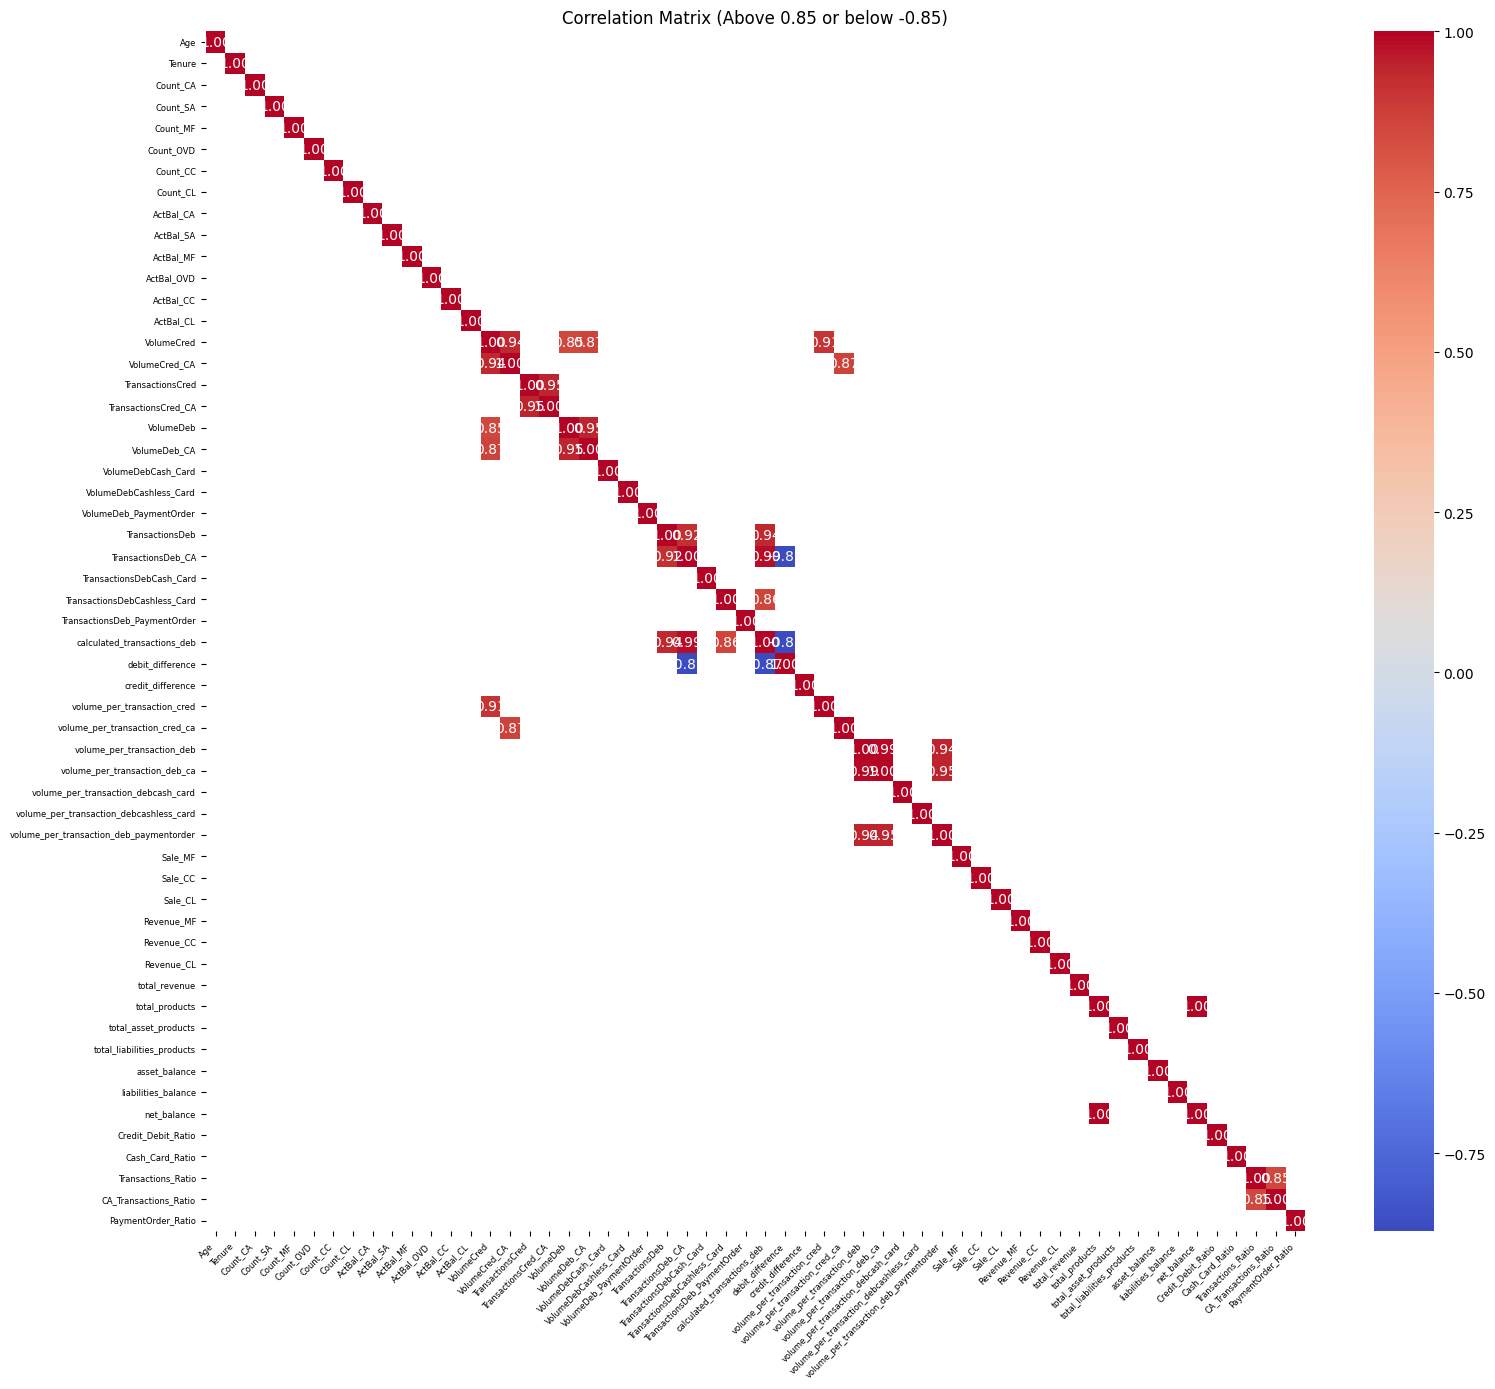

In [466]:
pairs_85_percent = correlation_plot(merged_df[num_vars], 0.85)

In [467]:
pairs_85_percent

[('VolumeCred', 'VolumeCred_CA', 0.9371985925929521),
 ('VolumeCred', 'VolumeDeb', 0.8536483000981058),
 ('VolumeCred', 'VolumeDeb_CA', 0.867539559736637),
 ('VolumeCred', 'volume_per_transaction_cred', 0.9103272560684623),
 ('VolumeCred_CA', 'volume_per_transaction_cred_ca', 0.867162004240582),
 ('TransactionsCred', 'TransactionsCred_CA', 0.9483359637764514),
 ('VolumeDeb', 'VolumeDeb_CA', 0.9450992119775663),
 ('TransactionsDeb', 'TransactionsDeb_CA', 0.9195391400139078),
 ('TransactionsDeb', 'calculated_transactions_deb', 0.9391556571111216),
 ('TransactionsDeb_CA', 'calculated_transactions_deb', 0.9852648210837107),
 ('TransactionsDeb_CA', 'debit_difference', -0.8676311852002172),
 ('TransactionsDebCashless_Card',
  'calculated_transactions_deb',
  0.8592390482954927),
 ('calculated_transactions_deb', 'debit_difference', -0.8722577909419198),
 ('volume_per_transaction_deb',
  'volume_per_transaction_deb_ca',
  0.9890812995627581),
 ('volume_per_transaction_deb',
  'volume_per_trans

In [468]:
to_drop_cols = []
# to_drop_cols.append('age_group')
for pair in pairs_85_percent:
    to_drop_cols.append(pair[1])
print(to_drop_cols)

['VolumeCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'volume_per_transaction_cred', 'volume_per_transaction_cred_ca', 'TransactionsCred_CA', 'VolumeDeb_CA', 'TransactionsDeb_CA', 'calculated_transactions_deb', 'calculated_transactions_deb', 'debit_difference', 'calculated_transactions_deb', 'debit_difference', 'volume_per_transaction_deb_ca', 'volume_per_transaction_deb_paymentorder', 'volume_per_transaction_deb_paymentorder', 'net_balance', 'CA_Transactions_Ratio']


In [469]:
# Drop the columns with high correlation
try:
  merged_df_corr_removed = merged_df.drop(columns=to_drop_cols)
except Exception as e:
  print("Already dropped")

In [470]:
num_vars = [var for var in num_vars if var not in to_drop_cols]

In [551]:
def apply_transformations_with_validation(df_original, numeric_cols, threshold=0.5, shapiro_threshold=0.05):
    """
    Apply Yeo-Johnson and Square Root transformations and validate using Shapiro-Wilk test.

    Args:
    df_original (pandas.DataFrame): Input DataFrame
    numeric_cols (list): List of all numeric columns
    threshold (float): Skewness threshold to determine if a column is skewed
    shapiro_threshold (float): Significance level for Shapiro-Wilk test

    Returns:
    pandas.DataFrame: DataFrame with transformed columns
    dict: Dictionary of applied transformations
    """
    df = df_original.copy()
    transformations = {}
    pt = PowerTransformer(method='yeo-johnson', standardize=False)

    for col in numeric_cols:
        # Check initial skewness
        original_skewness = stats.skew(df[col].dropna())

        # Check if column is skewed
        if abs(original_skewness) > threshold:
            # Reshape the data for PowerTransformer
            col_data = df[col].values.reshape(-1, 1)

            # Apply Yeo-Johnson transformation
            transformed_data_yeo = pt.fit_transform(col_data).flatten()
            _, p_value_yeo = stats.shapiro(transformed_data_yeo)

            # Check if Yeo-Johnson transformation is successful
            if p_value_yeo > shapiro_threshold:
                print(f"Yeo-Johnson transformation successful for {col} (p-value: {p_value_yeo:.4f})")
                df[col] = transformed_data_yeo
                transformations[col] = 'yeo_johnson'
                continue  # Skip to the next column since we've already transformed

            # Apply Square Root transformation
            transformed_data_sqrt = np.sqrt(df[col].dropna() - df[col].min() + 1)  # Shift to avoid negatives
            _, p_value_sqrt = stats.shapiro(transformed_data_sqrt)

            # Check if Square Root transformation is successful
            if p_value_sqrt > shapiro_threshold:
                print(f"Square Root transformation successful for {col} (p-value: {p_value_sqrt:.4f})")
                df[col] = transformed_data_sqrt
                transformations[col] = 'sqrt'
            else:
                print(f"Both transformations unsuccessful for {col} (Yeo-Johnson p-value: {p_value_yeo:.4f}, "
                      f"Square Root p-value: {p_value_sqrt:.4f})")

    return df, transformations

In [553]:
df_transformed, transformations = apply_transformations_with_validation(merged_df_corr_removed, num_vars)

Both transformations unsuccessful for Count_CA (Yeo-Johnson p-value: 0.0000, Square Root p-value: 0.0000)
Both transformations unsuccessful for Count_SA (Yeo-Johnson p-value: 0.0000, Square Root p-value: 0.0000)
Both transformations unsuccessful for Count_MF (Yeo-Johnson p-value: 0.0000, Square Root p-value: 0.0000)
Both transformations unsuccessful for Count_OVD (Yeo-Johnson p-value: 0.0000, Square Root p-value: 0.0000)
Both transformations unsuccessful for Count_CC (Yeo-Johnson p-value: 0.0000, Square Root p-value: 0.0000)
Both transformations unsuccessful for Count_CL (Yeo-Johnson p-value: 0.0000, Square Root p-value: 0.0000)
Both transformations unsuccessful for ActBal_CA (Yeo-Johnson p-value: 0.0000, Square Root p-value: 0.0000)
Both transformations unsuccessful for ActBal_SA (Yeo-Johnson p-value: 0.0000, Square Root p-value: 0.0000)
Both transformations unsuccessful for ActBal_MF (Yeo-Johnson p-value: 0.0000, Square Root p-value: 0.0000)
Both transformations unsuccessful for ActB

- Yeo-Johnson and Sqrt transformation wasn't applied to any column. It indicates that the transformed data still does not follow a normal distribution, suggesting that the transformation may not have been effective.

# Modelling

In [660]:
def prepare_data_for_modeling(df, target_col, client_col='Client'):
    """
    Prepare data for modeling by preprocessing features.

    Args:
    df (pd.DataFrame): Input DataFrame containing all relevant data.
    target_col (str): Target column name for propensity modeling (e.g., 'Sale_CL').
    revenue_col (str): Target column name for revenue prediction (e.g., 'Revenue_CL').
    client_col (str): Client identifier column (default is 'Client').

    Returns:
    tuple: Preprocessed features (X) and target variables (y_propensity, y_revenue).
    """
    # Exclude client and target columns from features. Also exclude total_revenue
    exclude_cols = [
        target_col, client_col,
        'Sale_MF', 'Sale_CC', 'Sale_CL',
        'Revenue_MF', 'Revenue_CC', 'Revenue_CL', 'total_revenue'
    ]

    feature_cols = [col for col in df.columns if col not in exclude_cols]

    # Separate features and target
    X = df[feature_cols]
    y_propensity = df[target_col]
    y_revenue = df[revenue_col]
    return X, y_propensity, y_revenue

In [661]:
def create_preprocessor(X, num_vars):
    """
    Create preprocessing pipeline for numeric features only.

    Args:
    X (pd.DataFrame): Features
    num_vars (list): List of numeric columns

    Returns:
    ColumnTransformer: Preprocessing transformer
    """
    # Only scale numeric features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_vars)
        ])

    return preprocessor

In [662]:
def perform_feature_selection_discrete(X, y, n_features_to_select=10):
    """
    Perform feature selection using RandomForest feature importance.

    Args:
    X (pd.DataFrame): Features
    y (pd.Series): Target variable

    Returns:
    list: Selected feature names
    """
    selector = SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42),
        max_features=n_features_to_select
    )
    selector.fit(X, y)
    selected_feature_indices = selector.get_support(indices=True)

    return X.columns[selected_feature_indices].tolist()

In [663]:
def perform_feature_selection_continuous(X, y, method='random_forest', n_features_to_select=10):
    """
    Perform feature selection for continuous target variables.

    Args:
    X (pd.DataFrame): Features
    y (pd.Series): Target variable (continuous)
    method (str): Method to use for feature selection ('linear_regression' or 'random_forest')
    n_features_to_select (int): Number of top features to select

    Returns:
    list: Selected feature names
    """

    if method == 'linear_regression':
        # Fit a linear regression model
        model = LinearRegression()
        model.fit(X, y)

        # Get absolute coefficients and sort them
        importance = np.abs(model.coef_)
        indices = np.argsort(importance)[-n_features_to_select:]

        return X.columns[indices].tolist()

    elif method == 'random_forest':
        # Fit a Random Forest Regressor
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)

        # Use SelectFromModel to select features based on importance
        selector = SelectFromModel(model, threshold=-np.inf, max_features=n_features_to_select)
        selector.fit(X, y)

        selected_feature_indices = selector.get_support(indices=True)

        return X.columns[selected_feature_indices].tolist()

    else:
        raise ValueError("Method must be 'linear_regression' or 'random_forest'.")

In [664]:
def train_propensity_model(X, y_propensity, num_vars):
    """
    Train a Random Forest Classifier for propensity modeling with feature selection,
    grid search for hyperparameter tuning, and cross-validation.

    Args:
    X (pd.DataFrame): Input feature DataFrame containing all relevant features.
    y_propensity (pd.Series): Discrete target variable for propensity modeling (e.g., 'Sale_CL').
    num_vars (list): List of numeric column names to be scaled in preprocessing.

    Returns:
    tuple: Best trained model and list of selected feature names.

    Raises:
    ValueError: If no features are selected after feature selection.
    """
    # Perform feature selection
    selected_features = perform_feature_selection_discrete(X, y_propensity)
    X_selected = X[selected_features]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y_propensity, test_size=0.2, random_state=42
    )

    # filter num_vars only if they are in selected_features
    filtered_num_vars = [var for var in num_vars if var in selected_features]

    # Preprocessor
    preprocessor = create_preprocessor(X_selected, filtered_num_vars)

    # Hyperparameter grid
    param_grid = {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [None, 5, 10],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__class_weight': ['balanced']
    }

    # Propensity model pipeline
    propensity_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    # Grid search with cross-validation
    grid_search = GridSearchCV(
        propensity_pipeline,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    # Fit grid search
    grid_search.fit(X_train, y_train)

    # Best model evaluation
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print("\nPropensity Model Performance:")
    print(classification_report(y_test, y_pred))

    # Cross-validation scores
    cv_scores = cross_val_score(
        best_model, X_train, y_train,
        cv=5, scoring='roc_auc'
    )
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f}")

    return best_model, selected_features

In [665]:
def train_revenue_model(X, y_revenue, num_vars):
    """
    Train a Random Forest Regressor for revenue prediction with feature selection,
    grid search for hyperparameter tuning, and cross-validation.

    Args:
    X (pd.DataFrame): Input feature DataFrame containing all relevant features.
    y_revenue (pd.Series): Continuous target variable for revenue prediction (e.g., 'Revenue_CL').
    num_vars (list): List of numeric column names to be scaled in preprocessing.

    Returns:
    tuple: Best trained model and list of selected feature names.

    Raises:
    ValueError: If no features are selected after feature selection.
    """
    # Perform feature selection
    selected_features = perform_feature_selection_continuous(X, y_revenue)
    X_selected = X[selected_features]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y_revenue, test_size=0.2, random_state=42
    )

    # filter num_vars only if they are in selected_features
    filtered_num_vars = [var for var in num_vars if var in selected_features]

    # Preprocessor
    preprocessor = create_preprocessor(X_selected, filtered_num_vars)

    # Hyperparameter grid
    param_grid = {
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [None, 5, 10],
        'regressor__min_samples_split': [2, 5, 10]
    }

    # Revenue model pipeline
    revenue_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])

    # Grid search with cross-validation
    grid_search = GridSearchCV(
        revenue_pipeline,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Fit grid search
    grid_search.fit(X_train, y_train)

    # Best model evaluation
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print("\nRevenue Model Performance:")
    print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")

    # Cross-validation scores
    cv_scores = cross_val_score(
        best_model, X_train, y_train,
        cv=5, scoring='neg_mean_squared_error'
    )
    print(f"Cross-validation scores: {-cv_scores}")
    print(f"Mean CV Score: {-cv_scores.mean():.4f}")

    return best_model, selected_features

In [666]:
def run_modeling(df):
   """
   Execute comprehensive modeling for multiple products, including propensity
    and revenue prediction.

    This function performs the following key steps for each product:
    1. Prepare data for modeling
    2. Perform feature selection
    3. Train propensity and revenue models
    4. Generate propensity scores and expected revenues
    5. Combine scores to assess client potential

    Args:
    df (pd.DataFrame): Input DataFrame containing all client and product information.
    num_vars (list): List of numeric column names to be used for feature scaling.

    Returns:
    dict: Comprehensive modeling results for each product, containing:
        - Trained propensity model
        - Trained revenue model
        - Combined scores indicating client potential

    Raises:
    ValueError: If data preparation or model training fails for any product.
   """
   products = {
       'consumer_loan': {
           'target_col': 'Sale_CL',
           'revenue_col': 'Revenue_CL'
       },
       'credit_card': {
           'target_col': 'Sale_CC',
           'revenue_col': 'Revenue_CC'
       },
       'mutual_fund': {
           'target_col': 'Sale_MF',
           'revenue_col': 'Revenue_MF'
       }
   }

   results = {}

   for product in products.keys():
       print(f"\nBegin for {product}")
       target_col = products[product]['target_col']
       revenue_col = products[product]['revenue_col']

       # Prepare data
       X, y_propensity, y_revenue = prepare_data_for_modeling(df, target_col, revenue_col)

       # Train models
       print(f"Running propensity model")
       propensity_model, selected_features = train_propensity_model(X, y_propensity, num_vars)
       print(f"Running revenue model")
       revenue_model, selected_features = train_revenue_model(X, y_revenue, num_vars)

       # Predict propensity and expected revenues for all clients
       propensity_scores = propensity_model.predict_proba(X)[:, 1]
       expected_revenues = revenue_model.predict(X)

       # Combine scores to determine potential value of each client
       combined_scores = propensity_scores * expected_revenues

       results[product] = {
           'propensity_model': propensity_model,
           'revenue_model': revenue_model,
           'combined_scores': combined_scores,
       }

   return results

### Run modelling

In [644]:
# Run the modelling
results = run_modeling(df_transformed)


Begin for consumer_loan
Running propensity model

Propensity Model Performance:
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89       268
         1.0       0.23      0.05      0.09        55

    accuracy                           0.81       323
   macro avg       0.53      0.51      0.49       323
weighted avg       0.73      0.81      0.76       323

Cross-validation scores: [0.57035327 0.64733039 0.59776142 0.53877181 0.61308864]
Mean CV Score: 0.5935
Running revenue model

Revenue Model Performance:
R2 Score: 0.0533
MSE: 74.6621
Cross-validation scores: [26.10827928 31.04809914 27.39961528 33.00640046 32.49122985]
Mean CV Score: 30.0107

Begin for credit_card
Running propensity model

Propensity Model Performance:
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       271
         1.0       0.13      0.13      0.13        52

    accuracy                           0.72       323
 

In [646]:
results['consumer_loan']

{'propensity_model': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['Age', 'Tenure', 'ActBal_CA',
                                                    'VolumeCred',
                                                    'VolumeDeb_PaymentOrder',
                                                    'TransactionsDeb',
                                                    'volume_per_transaction_deb',
                                                    'Credit_Debit_Ratio',
                                                    'Transactions_Ratio'])])),
                 ('classifier',
                  RandomForestClassifier(class_weight='balanced', max_depth=10,
                                         min_samples_split=5,
                                         random_state=42))]),
 'revenue_model': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[(

## Assign best offer and calculate the expected revenue

In [647]:
def assign_best_offer(row):
    """
    Assign the best offer based on expected revenues across multiple products.

    This function evaluates the expected revenues for different products
    and determines which product offers the highest potential revenue for a client.

    Args:
    row (pd.Series): A row from a DataFrame containing expected revenue values
                     for different products

    Returns:
    pd.Series: A Series containing:
        - 'Offer': The product with the highest expected revenue for a client.
        - 'Max_Expected_Revenue': The corresponding maximum expected revenue from that product for the client.
    """
    expected_revenues = {
        "consumer_loan": row['Expected_Revenue_CL'],
        "credit_card": row['Expected_Revenue_CC'],
        "mutual_fund": row['Expected_Revenue_MF']
    }

    # Find the product with maximum expected revenue
    best_offer = max(expected_revenues, key=expected_revenues.get)
    max_revenue = expected_revenues[best_offer]

    return pd.Series({
        'Offer': best_offer,
        'Max_Expected_Revenue': max_revenue
    })

In [649]:
def select_top_clients(results, df):
    """
    Select top 15% clients across all products based on maximum expected revenue.

    This function performs a comprehensive client selection process by:
    1. Aggregating expected revenues from different product models
    2. Assigning the best offer for each client
    3. Ranking clients based on their maximum expected revenue
    4. Selecting the top 15% most promising clients

    Args:
    results (dict): Comprehensive modeling results from run_modeling, containing:
        - Combined scores for each product
        - Trained propensity and revenue models
    df (pd.DataFrame): Original client DataFrame containing all client information

    Returns:
    pd.DataFrame: DataFrame of top clients with their recommended offers and expected revenues

    Raises:
    ValueError: If the results dictionary is incomplete or invalid
    KeyError: If required columns are missing in the input DataFrame
    """
    # Prepare a DataFrame to store expected revenues
    expected_revenues_df = pd.DataFrame({
        'Client': df['Client'],
        'Expected_Revenue_CL': results['consumer_loan']['combined_scores'],
        'Expected_Revenue_CC': results['credit_card']['combined_scores'],
        'Expected_Revenue_MF': results['mutual_fund']['combined_scores']
    })

    # Assign best offer and maximum expected revenue
    expected_revenues_df[['Offer', 'Max_Expected_Revenue']] = expected_revenues_df.apply(
        assign_best_offer, axis=1
    )

    # Sort by maximum expected revenue in descending order
    expected_revenues_df_sorted = expected_revenues_df.sort_values(
        by='Max_Expected_Revenue',
        ascending=False
    ).reset_index(drop=True)

    # Select top 15% clients
    num_clients_to_select = int(len(expected_revenues_df) * 0.15)
    targeted_clients = expected_revenues_df_sorted.head(num_clients_to_select)

    # Calculate total expected revenue
    total_expected_revenue = targeted_clients['Max_Expected_Revenue'].sum()

    print(f"\nTotal Expected Revenue from Top Clients: ${total_expected_revenue:,.2f}")
    print(f"Number of Targeted Clients: {len(targeted_clients)}")

    return targeted_clients

In [652]:
final_recommendations = select_top_clients(results, df_transformed)


Total Expected Revenue from Top Clients: $681.35
Number of Targeted Clients: 242


In [659]:
0.15*(len(df_social_dem['Client']))

242.25

In [668]:
final_recommendations[['Client', 'Offer', 'Max_Expected_Revenue']].head()

,Client,Offer,Max_Expected_Revenue
0,1169,consumer_loan,11.598367
1,1231,consumer_loan,9.909784
2,509,consumer_loan,8.308452
3,1583,consumer_loan,8.137160
4,642,consumer_loan,7.442706


           Offer  Count  Percentage
0  consumer_loan    157   64.876033
1    credit_card     52   21.487603
2    mutual_fund     33   13.636364


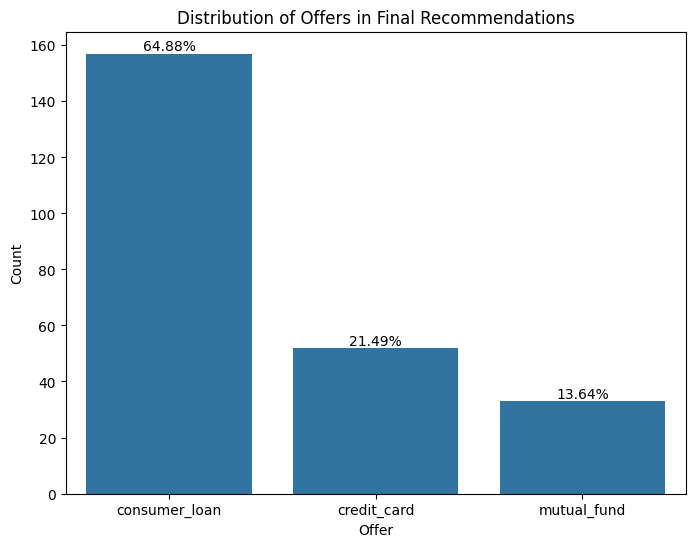

In [670]:
# Calculate the distribution of offers
offer_counts = final_recommendations['Offer'].value_counts()
total_offers = len(final_recommendations)

# Create a DataFrame for better visualization
offer_distribution = pd.DataFrame({
    'Offer': offer_counts.index,
    'Count': offer_counts.values,
    'Percentage': (offer_counts.values / total_offers) * 100
})

# Display the distribution
print(offer_distribution)

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Offer', y='Count', data=offer_distribution)
plt.title('Distribution of Offers in Final Recommendations')
plt.xlabel('Offer')
plt.ylabel('Count')

# Add percentage labels on top of the bars
for index, row in offer_distribution.iterrows():
    plt.text(index, row['Count'], f"{row['Percentage']:.2f}%", ha='center', va='bottom')

plt.show()

In [672]:
final_recommendations[['Client', 'Offer']].to_csv('./targeted_client_offer_list.csv', index=False)